Simulate multiple models of students with varying noise and compare diligence estimates with each

# Setup

In [1]:
import sys
sys.path.append("../lib")

In [2]:
import math
import random
import uuid
import os
import copy
import itertools
from collections.abc import Iterable
import datetime as dt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import Bounds
from scipy.optimize import minimize
from scipy import optimize
from scipy.stats import pearsonr

from sklearn.cluster import DBSCAN
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import FactorAnalysis

from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer import FactorAnalyzer

import statsmodels.api as sm



In [3]:
import logging

#logging.basicConfig(level=logging.DEBUG)
logging.basicConfig(level=logging.INFO)
#logging.basicConfig(level=logging.WARNING)

logger = logging.getLogger("main")

In [4]:
#logging.getLogger().setLevel(logging.DEBUG)
logging.getLogger().setLevel(logging.INFO)
#logging.getLogger().setLevel(logging.WARNING)
logger.debug("Test debug")
logger.info("Test info")
logger.warning("Test warning")

INFO:main:Test info


In [5]:
# from tutor.domain import Domain
from tutor.curriculum_factory import CurriculumFactory
from tutor.simple_curriculum import SimpleCurriculum
from tutor.tutor import SimpleTutor
from tutor.action import Attempt, HintRequest

In [6]:
from learner.selfeff_learner import SelfEfficacyLearner
from learner.modular_learner import ModularLearner
from learner.cognition import *
from learner.decider import *

In [7]:
from simulate.modlearner_simulation import ModLearnerSimulation
from simulate.simulation import *
from simulate.script_helpers import SimHelper

In [8]:
from analytics.student_stats import *
from analytics.cae import *
from analytics.featurization import *
from analytics.batch import *
from analytics.step import *
from analytics.transaction import *
from analytics.session import *

In [9]:
from log_db import mongo
from log_db.curriculum_mapper import DB_Curriculum_Mapper
from log_db.learner_mapper import DBLearnerMapper

In [10]:
from CanonicalAutocorrelationAnalysis.model.caa import CAAComputation
from CanonicalAutocorrelationAnalysis.model.caaObject import *
from CanonicalAutocorrelationAnalysis.model.utils import l1Norm, l2Norm, r2Compute

In [11]:
# Get path to current project directory
cwd = os.path.abspath(".")
base_dir = os.path.abspath(os.path.join(cwd, os.pardir))
logger.info("Base directory for the project:\n%s" % base_dir)

INFO:analytics.session:Base directory for the project:
/rdata/Sandbox/MotivSim


In [12]:
# Setup connection to database
data_out = "sim-%s" % str(uuid.uuid4())
data_path = os.path.join(base_dir,"test", "data", data_out)
logger.info("Writing simulation results to directory: %s" % data_path)
db_name = "motivsim"
db_params  = mongo.get_db_params(db_name)
logger.info("got db params: %s" % str(db_params))
db_util = mongo.Data_Utility(data_path, db_params)
db = db_util.db

INFO:analytics.session:Writing simulation results to directory: /rdata/Sandbox/MotivSim/test/data/sim-c06eba32-ea1d-4375-a2e4-135fed63622c
INFO:analytics.session:got db params: {'settingId': 'motivsim', 'url': 'localhost', 'port': '27017', 'name': 'motivsim', 'user': '', 'pswd': ''}


In [13]:
# Test db connection
db_util.peak()

INFO:log_db.mongo:collection name, kcs, has 0 documents
INFO:log_db.mongo:collection name, caa_batches, has 0 documents
INFO:log_db.mongo:collection name, simbatches, has 0 documents
INFO:log_db.mongo:collection name, sessions, has 0 documents
INFO:log_db.mongo:collection name, caa_models, has 0 documents
INFO:log_db.mongo:collection name, domains, has 0 documents
INFO:log_db.mongo:collection name, students, has 0 documents
INFO:log_db.mongo:collection name, units, has 0 documents
INFO:log_db.mongo:collection name, decisions, has 0 documents
INFO:log_db.mongo:collection name, curriculums, has 0 documents
INFO:log_db.mongo:collection name, steps, has 0 documents
INFO:log_db.mongo:collection name, finalsimstudents, has 0 documents
INFO:log_db.mongo:collection name, problems, has 0 documents
INFO:log_db.mongo:collection name, actions, has 0 documents
INFO:log_db.mongo:collection name, sections, has 0 documents
INFO:log_db.mongo:collection name, tutor_events, has 0 documents
INFO:log_db.mo

In [14]:
clear_db = True
if clear_db:
    logger.info("Clearing database before starting new simulation")
    db_util.clear_db()
else:
    logger.info("Skipping Clearing database")

INFO:analytics.session:Clearing database before starting new simulation


# Simulating learners

In [15]:
num_students = 100
num_sessions = 20

In [16]:
sim_helper = SimHelper(db)

In [17]:
def get_cog_params():
    ability = -2
    while (ability < -1) or (ability > 1):
        ability = np.random.normal(0, 0.6)
    return {"ability": ability}

def gen_students(num_students, domain, curric, 
                 cog_mod, cog_params, dec_mod, dec_params):
    stus = []
    for i in range(num_students):
        cp = cog_params()
        cog = cog_mod(domain, **cp)
        dp = dec_params()
        dec = dec_mod(**dp)
        decider = DiligentDecider(dec)
        stu = ModularLearner(domain, cog, decider)
        stus.append(stu)
        
    return stus

def simulate_students(curric, students, batch):    
    
    env = simpy.Environment()

    mastery_thres = 0.95
    m_ses_len = 45
    sd_ses_len = 8
    max_ses_len = 60
    sim_start = dt.datetime.now()

    mod = round(len(students) / 10)
#     mod = 1
    for i, stu in enumerate(students):
        if i % mod == 0:
            logger.info("Simulating student #%i" % i)
        # Create associated tutor
        tutor = SimpleTutor(curric, stu._id, mastery_thres)

        # Initialize simulation processes
        sim = SingleStudentSim(db, env, sim_start, stu, tutor,
                               num_sessions, m_ses_len, sd_ses_len, max_ses_len)
        batch.add_sim(sim)

        env.process(sim.run())

    env.run()
                
    logger.info("Inserting %i simulated students to db" % len(students))
    result = db.finalsimstudents.insert_many([stu.to_dict() for stu in students])
    logger.info("Db insert success: %s" % result.acknowledged)

    logger.info("Inserting simulation batch to db")
    result = db.simbatches.insert_one(batch.to_dict())
    logger.info("Db insert success: %s" % result.acknowledged)

    return batch, students


In [18]:
new_curric = None
new_domain = None

In [19]:
def get_domain_params(params=None):
    if params is None:
        #params = [0.7 , 0.05, 0.05, 0.01, 0.15, 0.05, 0.3 , 0.1 , 0.5 , 0.02]
        params = [0.4 , 0.1, 0.1, 0.03, 0.1, 0.05, 0.1 , 0.05 , 0.1 , 0.07]
    param_keys = ['m_l0', 'sd_l0', 'm_l0_sd', 'sd_l0_sd', 'm_t',
                'sd_t', 'm_s','sd_s', 'm_g', 'sd_g']
    domain_params = {k:v for k,v in zip(param_keys, params)}
    return domain_params

def gen_test_curric(db, db_params):
    global new_curric, new_domain
    if new_curric is None:
        logger.info("Generating new curriculum")
        
        domain_params = get_domain_params()


        curric_params = {'num_units': 20,
                         'mean_sections': 4,
                         'stdev_sections': 2,
                         'mean_unit_kcs': 22,
                         'stdev_unit_kcs': 23,
                         'section_kcs_lambda': 6,
                         'mean_steps': 10,
                         'stdev_steps': 4,
                         'mean_prob_kcs': 6,
                         'stdev_prob_kcs': 3,
                         'num_practice': 100
                        }

        domain, curric = CurriculumFactory.gen_curriculum(domain_params, curric_params)
        db.domains.insert_one(domain.to_dict())
        db.kcs.insert_many([kc.__dict__ for kc in domain.kcs])
        curric_util = DB_Curriculum_Mapper(db_params)
        curric_util.write_to_db(curric)
        
        new_curric = curric
        new_domain = domain

        return domain, curric
    else:
        logger.info("New curriculum already generated")
        return new_domain, new_curric

In [20]:
def get_sim_batch(desc):
    simbatch = db.simbatches.find_one({"desc": desc})
    if simbatch is None:
        logger.info("Generating new simulation. None found in db")

        # generate simualted data for test
        domain, curric = gen_test_curric(db, db_params)
        students = gen_students(num_students, domain, curric, 
                                cog_mod, get_cog_params, 
                                dec_mod, get_dec_params)   
        logger.info(f"Persisting {len(students)} initialized students to db")
        db.students.insert_many([stu.to_dict() for stu in students])
        batch = SimulationBatch(desc)
        simulate_students(curric, students, batch)    
        logger.info(f"Simulated {len(students)} in batch with id: {batch._id}")
    else:
        logger.info(f"Found simulation batch: {str(simbatch['desc'])}")
        lmapper = DBLearnerMapper(db)
        students = [lmapper.get_modlearner_from_db(sid) for sid in simbatch['student_ids']]
        batch = SimulationBatch.from_dict(simbatch)
        logger.info(f"Recovered {len(students)} students from batch with id: {batch._id}")
        
    return students, batch

## Simple Diligent students

In [21]:
sim_batch_desc = "Simple diligent students"
cog_mod = BiasSkillCognition
dec_mod = EVDecider

def get_cog_params():
    # Helper for getting parameters for BiasSkillCognition Module
    ability = random.triangular(-1,1)
    #logger.info(f"Generating student with ability: {ability}")
    return {'ability': ability}

def get_dec_params():
    return {}

In [22]:
students, batch = get_sim_batch(sim_batch_desc)

INFO:analytics.session:Generating new simulation. None found in db
INFO:analytics.session:Generating new curriculum
INFO:tutor.cogtutor_curriculum:Generated 20 units with with a total of 762 kcs
INFO:log_db.curriculum_mapper:Writing curriculum with id, c115728c-03a8-4f81-84e8-d98b30a3eafc, to db
INFO:log_db.curriculum_mapper:Writing 21342 problem to db
INFO:log_db.curriculum_mapper:Writing 89006 steps to db
INFO:analytics.session:Persisting 100 initialized students to db
INFO:analytics.session:Simulating student #0
INFO:analytics.session:Simulating student #10
INFO:analytics.session:Simulating student #20
INFO:analytics.session:Simulating student #30
INFO:analytics.session:Simulating student #40
INFO:analytics.session:Simulating student #50
INFO:analytics.session:Simulating student #60
INFO:analytics.session:Simulating student #70
INFO:analytics.session:Simulating student #80
INFO:analytics.session:Simulating student #90
INFO:analytics.session:Inserting 100 simulated students to db
INF

## Self Efficacy Diligent students

In [23]:
sim_batch_desc = "Self-Efficacy students"
cog_mod = BiasSkillCognition
dec_mod = DomainSelfEffDecider

def get_cog_params():
    # Helper for getting parameters for BiasSkillCognition Module
    return {'ability': random.triangular(-1,1)}

def get_dec_params():
    se = -1
    while (se <= 0) or (se >1):
        se = random.gauss(0.5, 0.2)
    return {'attr': {'self_eff': se}}

In [24]:
students, batch = get_sim_batch(sim_batch_desc)

INFO:analytics.session:Generating new simulation. None found in db
INFO:analytics.session:New curriculum already generated
INFO:analytics.session:Persisting 100 initialized students to db
INFO:analytics.session:Simulating student #0
INFO:analytics.session:Simulating student #10
INFO:analytics.session:Simulating student #20
INFO:analytics.session:Simulating student #30
INFO:analytics.session:Simulating student #40
INFO:analytics.session:Simulating student #50
INFO:analytics.session:Simulating student #60
INFO:analytics.session:Simulating student #70
INFO:analytics.session:Simulating student #80
INFO:analytics.session:Simulating student #90
INFO:analytics.session:Inserting 100 simulated students to db
INFO:analytics.session:Db insert success: True
INFO:analytics.session:Inserting simulation batch to db
INFO:analytics.session:Db insert success: True
INFO:analytics.session:Simulated 100 in batch with id: 103b06b7-8c5d-4494-8bef-8058517f1502


## Intrinsic Interest Diligent students

In [25]:
sim_batch_desc = "Intrinsic Interest students"
cog_mod = BiasSkillCognition
dec_mod = MathInterestDecider

def get_cog_params():
    # Helper for getting parameters for BiasSkillCognition Module
    return {'ability': random.triangular(-1,1)}

def get_dec_params():
    return {'attr': {'interest': np.random.normal(0,1)}}

In [26]:
students, batch = get_sim_batch(sim_batch_desc)

INFO:analytics.session:Generating new simulation. None found in db
INFO:analytics.session:New curriculum already generated
INFO:analytics.session:Persisting 100 initialized students to db
INFO:analytics.session:Simulating student #0
INFO:analytics.session:Simulating student #10
INFO:analytics.session:Simulating student #20
INFO:analytics.session:Simulating student #30
INFO:analytics.session:Simulating student #40
INFO:analytics.session:Simulating student #50
INFO:analytics.session:Simulating student #60
INFO:analytics.session:Simulating student #70
INFO:analytics.session:Simulating student #80
INFO:analytics.session:Simulating student #90
INFO:analytics.session:Inserting 100 simulated students to db
INFO:analytics.session:Db insert success: True
INFO:analytics.session:Inserting simulation batch to db
INFO:analytics.session:Db insert success: True
INFO:analytics.session:Simulated 100 in batch with id: 73c500b3-cf58-491b-84c2-28ad744f171a


## Self-eff/Interest Diligent students

In [27]:
sim_batch_desc = "Combo students"
cog_mod = BiasSkillCognition
dec_mod = MathIntSelfEffDecider

def get_cog_params():
    # Helper for getting parameters for BiasSkillCognition Module
    return {'ability': random.triangular(-1,1)}

def get_dec_params():
    se = -1
    while (se <= 0) or (se >1):
        se = random.gauss(0.5, 0.2)
    return {'attr': {'self_eff': se, 'interest': np.random.normal(0,1)}}

In [28]:
students, batch = get_sim_batch(sim_batch_desc)

INFO:analytics.session:Generating new simulation. None found in db
INFO:analytics.session:New curriculum already generated
INFO:analytics.session:Persisting 100 initialized students to db
INFO:analytics.session:Simulating student #0
INFO:analytics.session:Simulating student #10
INFO:analytics.session:Simulating student #20
INFO:analytics.session:Simulating student #30
INFO:analytics.session:Simulating student #40
INFO:analytics.session:Simulating student #50
INFO:analytics.session:Simulating student #60
INFO:analytics.session:Simulating student #70
INFO:analytics.session:Simulating student #80
INFO:analytics.session:Simulating student #90
INFO:analytics.session:Inserting 100 simulated students to db
INFO:analytics.session:Db insert success: True
INFO:analytics.session:Inserting simulation batch to db
INFO:analytics.session:Db insert success: True
INFO:analytics.session:Simulated 100 in batch with id: 868ac4c2-8ae2-48e5-9203-c09fc3bccc7a


# Estimating Diligence

Estimators to compare
1. Frequency of Off-task
2. Total Time 
3. Start Speed (procrastination)
4. Early Finish (persistence)
5. 2 Measure
6. 3 Measure
7. 4 Measure
8. Diligence & Cog Measures
4. M4: Multiple Diligence Measures
5. M5: Multiple Diligence & Multiple Cognitive Measure instrument
6: M6: Multiple diligence & Cog measures + CAE measures.

Seed Model

* Measures of Cognition
    * AFM intercept
    * Total Skills mastered

* Measures of Diligence
    * Total Time  
    * Frequency of Off-task
    * Start Speed
    * Early Finish



## Helpers

In [29]:
def get_stu_parameters(sids, mastery_thres):
    sim_students = calc.get_stu_attributes(sids)
    sim_students = pd.concat([sim_students, calc.get_mastery(sids, mastery_thres)], axis=1)
    return sim_students


In [30]:
def get_tx_fields(sids, fields=None):
    tx = pd.DataFrame(db.tutor_events.find({"stu_id": {'$in': sids}, "type": "TutorInput"}))
    # Add kc field that reduces list of kcs to 1 kc
    tx['kc'] = tx.apply(lambda x: x['kcs'][0]['_id'], axis=1)
    if fields is None:
        return tx
    else:
        return tx.loc[:, fields]

In [31]:
def get_tx(sids):
    tx = pd.DataFrame(db.tutor_events.find({"stu_id": {'$in': sids}, 'type': "TutorInput"}))
    tx.index = tx['_id']
    tx['kc'] = tx.explode('kcs')['kcs'].apply(lambda x: x['_id'])
    return tx

def lbl_nondil_tx(tx):
    detector = Detector(db) 
    gt_lblr = TransactionAnnotator(db)
    
    kc_long_tx = detector.get_kc_long_cutoff(tx)
    kc_short_tx = detector.get_kc_short_cutoff(tx)

    # Add Ground truth labels (using global db var)

    tx['is_offtask'] = gt_lblr.label_offtask_tx(tx)
    tx['is_guess'] = gt_lblr.label_guess_tx(tx)

    # Add detector labels
    tx['detect_offtask'] = detector.is_off_task(tx, kc_stats=kc_long_tx)
    tx['detect_guess'] = detector.is_guess(tx, kc_stats=kc_short_tx)
    return tx
    


In [32]:
def calc_accuracy(tx_stats):
    d =  tx_stats['Correct']/ tx_stats['Total Tx']
    d.rename("accuracy", inplace=True)
    return d

def calc_step_accuracy(steps):
    steps['is_correct'] = steps['outcome'] == 'Correct'
    step_acc = steps.groupby('stu_id')['is_correct'].apply(lambda x: np.sum(x) / len(x)).rename("step_accuracy")
    return step_acc
    

def calc_err_on_1_opp(tx):
    d = tx[tx['attempt'] == 0]
    # Get 1st opportunity
    cols = [col for col in d.columns if col not in ['stu_id', 'kc']]
    opp1 = d.groupby(['stu_id', 'kc']).apply(lambda x: x.iloc[0][cols]).reset_index()
    opp1['is_correct'] = opp1['outcome'] == "Correct"
    ## Calculate P(Correct) per student
    opp1 =  opp1.groupby('stu_id')['is_correct'].apply(lambda x: np.sum(x) / len(x))
    opp1.rename("err_on_1_opp", inplace=True)
    return opp1

def calc_avg_prac_opp(tx, mastery_thres=0.9):
    # Get the learner knowledge at the end of each practice step
    d = tx.groupby(['stu_id', 'kc', 'step_id'])['plt1'].apply(lambda x: x[-1]).reset_index()
    d['has_mastered'] = d['plt1'] >= mastery_thres
    # Getting student-kc pairings for analysis
    stu_kc = d.loc[d['has_mastered'], ['stu_id','kc']].drop_duplicates()
    # Get just tx for relevant stu-kc's
    d = pd.merge(tx, stu_kc, on=['stu_id', 'kc'], how='inner')
    d = tx[['stu_id', 'kc', 'step_id']].drop_duplicates().groupby(['stu_id', 'kc']).count().reset_index()
    d = d.groupby('stu_id')['step_id'].mean()
    d.rename('avg_prac_opp', inplace=True)
    return d

def calc_p_guess(tx):
    d = tx.groupby('stu_id')['detect_guess'].apply(lambda x: np.sum(x) / len(x))
    d.rename("p_guess", inplace=True)
    return d

def calc_detected_offtask(tx):
    if "detect_offtask" not in tx:
        tx = lbl_nondil_tx(tx)
    # Student-level off-task vs detected off-task
    d = tx.groupby("stu_id")['detect_offtask'].mean()

    d.rename("mean_detect_offtask", inplace=True)
    return d

def calc_detected_guess(tx):
    if "detect_guess" not in tx:
        tx = lbl_nondil_tx(tx)
    # Student-level off-task vs detected off-task
    d = tx.groupby("stu_id")['detect_guess'].mean()

    d.rename("mean_detect_guess", inplace=True)
    return d

def calc_time_on_task(tx):
    d = tx.pivot_table(index="stu_id", columns="is_offtask", values="duration", fill_value=0, aggfunc=np.sum).reset_index()
    d.index = d['stu_id']
    d.rename(columns={False: "time_on_task", True: "time_off_task"}, inplace=True)
    d.drop(columns=['stu_id'], inplace=True)
    d['time_on_task'] = d['time_on_task'] / 3600
    d['time_off_task'] = d['time_off_task'] / 3600
    return d

    
    


In [33]:
def get_student_sessions(sids):
    # Get login-logout transactions for students
    tx = pd.DataFrame(db.tutor_events.find({"stu_id": {'$in': sid}, "type": {"$in": ["SessionStart", "SessionEnd"]}}))
    ses_ids = tx['session_id'].unique().tolist()
    # Append session metadata
    sessions = pd.DataFrame(db.sessions.find({"_id": {'$in': ses_ids}}))
    sessions.drop(columns=['type'], inplace=True)
    sessions.rename(columns={"_id": "session_id"}, inplace=True)
    tx = pd.merge(tx, sessions, on="session_id", how='inner')
    return tx

def calc_session_stats(sids):
    tx = get_student_sessions(sids)
    
    # Calc student-session stats
    session_stats = tx.pivot(index=['stu_id', 'session_id'], columns='type', values='time').reset_index()
    session_stats = pd.merge(tx.loc[:, ['stu_id', 'session_id', 'start', 'end']].drop_duplicates(), session_stats, on=['stu_id', 'session_id'])

    # Start/end speed
    session_stats['start speed'] = session_stats.apply(lambda x: (x['SessionStart'] - x['start']).total_seconds()/60, axis=1)
    session_stats['early finish'] = session_stats.apply(lambda x: (x['end'] - x['SessionEnd']).total_seconds()/60, axis=1)

    # session length
    session_stats['session length'] = session_stats.apply(lambda x: (x['SessionEnd'] - x['SessionStart']).total_seconds()/60, axis=1)
    session_stats['class length'] = session_stats.apply(lambda x: (x['end'] - x['start']).total_seconds()/60, axis=1)
    session_stats['pct class'] = session_stats['session length'] / session_stats['class length']
    
    return session_stats

def calc_stu_session_stats(sids):
    session_stats = calc_session_stats(sids)
    stu_session_stats = session_stats.groupby('stu_id')['start speed', 'early finish', 'session length', 'pct class'].agg('mean', 'std')
    return stu_session_stats


def calc_student_dil_stats(sids):
    tx = get_tx(sid)
    tx = lbl_nondil_tx(tx)

    detect_offtask = calc_detected_offtask(tx)
    detect_guess = calc_detected_guess(tx)
    time_on_task = calc_time_on_task(tx)

    return pd.concat([detect_guess, detect_offtask, time_on_task], axis=1)



In [34]:
def calc_stats(ids):

    tx = get_tx(ids)
    tx = pd.concat([tx, tx_lblr.label_nondil_tx(tx)], axis=1)
    # Merge decisions with tx
    decisions, actions = tx_lblr.get_tx_decisions(tx)
    tx = tx_lblr.merge_decisions(tx, actions, decisions)


    # Get step rollup
    steps = step_calc.rollup_tx(tx)
    steps = pd.concat([steps, step_calc.label_knowledge(steps)], axis=1)
    # Label each step opportunity
    steps['opportunity'] = steps.groupby(['stu_id', 'kc']).cumcount()
    steps['opportunity'] += 1
    
    # Collect minimum steps information for running afm
    


    # Calculate student non-diligent stats
    detect_offtask = calc.calc_detected_offtask(tx)
    detect_guess = calc.calc_detected_guess(tx)
    time_on_task = calc.calc_time_on_task(tx)


    # Count opportunities at each knowledge level
    kc_prac = step_calc.count_practice_challenge(steps)
    over_prac = kc_prac.apply(lambda x: x['high_knowledge'] / np.sum(x), axis=1)
    
    
    # Calculate accuracy
    step_accuracy = calc_step_accuracy(steps)

    # Calculate work rate:
    work_rate = calc.calc_avg_work_rate(steps)
    # Calculate expected work time
    d = pd.DataFrame(db.kcs.find({"_id": {"$in": steps['kc'].tolist()}})).rename(columns={'_id': "kc"})
    steps = pd.merge(steps, d, on="kc", how="outer")
    steps['expected_duration'] = steps['Attempts'] * steps['m_time']
    exp_work_rate = steps.groupby('stu_id')['duration'].sum() / steps.groupby('stu_id')['expected_duration'].sum()

    # Calculate hint usage by knowledge level
    stu_level_hints = steps.groupby(['stu_id', 'knowledge_level'])['Hint'].mean()

    # Fit line for each student tendency to request hint
    
    steps[['stu_id', 'unit_id', 'section_id', 'prob_id', 'step_id', 'outcome', 'kc', 'opportunity']]
    student_label = steps['stu_id'].tolist()
    stu = [{s: 1} for s in student_label]
    item_label = steps[['unit_id', 'section_id', 'prob_id', 'step_id']].apply(lambda x: "##".join(x), axis=1).tolist()
    y = steps['outcome'].apply(lambda x: 1 if x == 'Correct' else 0)
    opps = [{kc: o} for kc, o in zip(steps['kc'].tolist(), steps['opportunity'].tolist())]
    kcs = [{kc: 1} for kc in steps['kc'].tolist()]
    

    
    # Calculate detector error
    # Plot Detector vs ground truth
    tx['offtask_tp'] = (tx['is_offtask'] == True) & (tx['detect_offtask'] == True)
    tx['offtask_fp'] = (tx['is_offtask'] == False) & (tx['detect_offtask'] == True)
    tx['offtask_tn'] = (tx['is_offtask'] == False) & (tx['detect_offtask'] == False)
    tx['offtask_fn'] = (tx['is_offtask'] == True) & (tx['detect_offtask'] == False)
    tx['guess_tp'] = (tx['is_guess'] == True) & (tx['detect_guess'] == True)
    tx['guess_fp'] = (tx['is_guess'] == False) & (tx['detect_guess'] == True)
    tx['guess_tn'] = (tx['is_guess'] == False) & (tx['detect_guess'] == False)
    tx['guess_fn'] = (tx['is_guess'] == True) & (tx['detect_guess'] == False)
    

    ot_err = tx.groupby('stu_id')[['offtask_tp', 'offtask_fp', 'offtask_tn', 'offtask_fn']].sum()

    g_err = tx.groupby('stu_id')[['guess_tp', 'guess_fp', 'guess_tn', 'guess_fn']].sum()
#     logger.info("Calculated detector error counts")

#     total_stats = {}
#     total_stats['ot_tp'] = np.sum(tx['offtask_tp']) / tx.shape[0]
#     total_stats['ot_fp'] = np.sum(tx['offtask_fp']) / tx.shape[0]
#     total_stats['ot_tn'] = np.sum(tx['offtask_tn']) / tx.shape[0]
#     total_stats['ot_fn'] = np.sum(tx['offtask_fn']) / tx.shape[0]



#     total_stats['g_tp'] = np.sum(tx['guess_tp']) / tx.shape[0]
#     total_stats['g_fp'] = np.sum(tx['guess_fp']) / tx.shape[0]
#     total_stats['g_tn'] = np.sum(tx['guess_tn']) / tx.shape[0]
#     total_stats['g_fn'] = np.sum(tx['guess_fn']) / tx.shape[0]
#     det_err[desc] = total_stats

    stats = pd.concat([detect_offtask, detect_guess, time_on_task, kc_prac, 
                       step_accuracy, over_prac, work_rate, exp_work_rate, 
                       ot_err, g_err], axis=1)
#     logger.info(f"Merged stats: {stats.shape}")
    return stats


In [35]:
def afm_stu_intercept(kcs, opps, actuals, stu, student_label, item_label, nfolds=3,
        seed=None):
    """
    Executes AFM on the provided data and returns model fits and parameter
    estimates
    """
    sv = DictVectorizer()
    qv = DictVectorizer()
    ov = DictVectorizer()

    S = sv.fit_transform(stu)
    Q = qv.fit_transform(kcs)
    O = ov.fit_transform(opps)

    X = hstack((S, Q, O))
    y = np.array(actuals)

    l2 = [1.0 for i in range(S.shape[1])]
    l2 += [0.0 for i in range(Q.shape[1])]
    l2 += [0.0 for i in range(O.shape[1])]

    bounds = [(None, None) for i in range(S.shape[1])]
    bounds += [(None, None) for i in range(Q.shape[1])]
    bounds += [(0, None) for i in range(O.shape[1])]

    X = X.toarray()
    X2 = Q.toarray()

    model = CustomLogistic(bounds=bounds, l2=l2, fit_intercept=False)
    model.fit(X, y)

    coef_s = model.coef_[0:S.shape[1]]
    coef_s = [[k, v, invlogit(v)]
              for k, v in sv.inverse_transform([coef_s])[0].items()]

    return coef_s

In [36]:
def get_afm_steps(sids):
    tx = get_tx(sids)
    
    # Minimalist Rollup steps
    #Step outcome
    step_outcomes = tx.sort_values('time').groupby(['stu_id', 'unit_id', 'section_id', 'prob_id', 'step_id'])['outcome'].first()
    # Get time stamp for last tx
    time = tx.groupby(['stu_id', 'unit_id', 'section_id', 'prob_id', 'step_id'])['time'].agg(lambda x: x.sort_values().iloc[-1])
    steps = pd.concat([step_outcomes, time], axis=1)
    # Get kc
    steps = pd.merge(steps, tx.loc[:, ['stu_id', 'unit_id', 'section_id', 'prob_id', 'step_id', 'kc' ]].drop_duplicates(), on=['stu_id', 'unit_id', 'section_id', 'prob_id', 'step_id'], how='inner')
    # Label each step opportunity
    steps['opportunity'] = steps.groupby(['stu_id', 'kc']).cumcount()
    steps['opportunity'] += 1
    
    return steps

def run_afm(steps):
    # Format data for passing to afm
    student_label = steps['stu_id'].tolist()
    stu = [{s: 1} for s in student_label]
    item_label = steps[['unit_id', 'section_id', 'prob_id', 'step_id']].apply(lambda x: "##".join(x), axis=1).tolist()
    y = steps['outcome'].apply(lambda x: 1 if x == 'Correct' else 0)
    opps = [{kc: o} for kc, o in zip(steps['kc'].tolist(), steps['opportunity'].tolist())]
    kcs = [{kc: 1} for kc in steps['kc'].tolist()]
    
    nfolds = 3
    seed = None
#     scores, kc_vals, coef_s = afm(kcs, opps, y, stu,
#                                   student_label, item_label, nfolds, seed)
    coef_s = afm_stu_intercept(kcs, opps, y, stu,
                                  student_label, item_label, nfolds, seed)
    stu_intercepts = pd.DataFrame(coef_s, columns=['stu_id', 'Intercept (logit)', 'Intercept (prob)'])
    stu_intercepts.index = stu_intercepts['stu_id']
    stu_intercepts.drop(columns=['stu_id'], inplace=True)
    return stu_intercepts

In [57]:
def cronbach_alpha(df):    # 1. Transform the df into a correlation matrix
    df_corr = df.corr()
    
    # 2.1 Calculate N
    # The number of variables equals the number of columns in the df
    N = df.shape[1]
    
    # 2.2 Calculate R
    # For this, we'll loop through the columns and append every
    # relevant correlation to an array calles "r_s". Then, we'll
    # calculate the mean of "r_s"
    rs = np.array([])
    for i, col in enumerate(df_corr.columns):
        sum_ = df_corr[col][i+1:].values
        rs = np.append(sum_, rs)
    mean_r = np.mean(rs)
    
   # 3. Use the formula to calculate Cronbach's Alpha 
    cronbach_alpha = (N * mean_r) / (1 + (N - 1) * mean_r)
    return cronbach_alpha

def CronbachAlpha(itemscores):
    itemscores = np.asarray(itemscores)
    itemvars = itemscores.var(axis=0, ddof=1)
    tscores = itemscores.sum(axis=1)
    nitems = itemscores.shape[1]

    return (nitems / (nitems-1)) * (1 - (itemvars.sum() / tscores.var(ddof=1)))

In [37]:
from scipy.sparse import hstack
from sklearn.feature_extraction import DictVectorizer

from pyafm.util import invlogit
from pyafm.custom_logistic import CustomLogistic

## Calculate Stats

In [38]:
# Calculating stats with analytic methods

calc = StudentStatCalc(db)
batch_calc = BatchCalculator()
detector = Detector(db)
tx_lblr = TransactionAnnotator(db)
step_calc = StepCalculator(db)
tx_calc = TransactionCalculator(db)
session_calc = SessionCalculator(db)

In [39]:
# Get students batches
batches = [batch for batch in db.simbatches.find()]
batch_descs = ["Simple diligent students",
               "Self-Efficacy students",
               "Intrinsic Interest students",
               "Combo students"
              ]
sids = {desc: [] for desc in batch_descs}
for i, batch in enumerate(batches):
    logger.info(f"batch #{i}: \nID: {batch['_id']}\ndesc: {batch['desc']}")
    if batch['desc'] in batch_descs:
        logger.info(f"recovered {len(batch['student_ids'])} student ids for batch {batch['desc']}")
        sids[batch['desc']].append(batch['student_ids'])

INFO:analytics.session:batch #0: 
ID: 12362503-07ba-408e-b149-017bca8f2ed8
desc: Simple diligent students
INFO:analytics.session:recovered 100 student ids for batch Simple diligent students
INFO:analytics.session:batch #1: 
ID: 103b06b7-8c5d-4494-8bef-8058517f1502
desc: Self-Efficacy students
INFO:analytics.session:recovered 100 student ids for batch Self-Efficacy students
INFO:analytics.session:batch #2: 
ID: 73c500b3-cf58-491b-84c2-28ad744f171a
desc: Intrinsic Interest students
INFO:analytics.session:recovered 100 student ids for batch Intrinsic Interest students
INFO:analytics.session:batch #3: 
ID: 868ac4c2-8ae2-48e5-9203-c09fc3bccc7a
desc: Combo students
INFO:analytics.session:recovered 100 student ids for batch Combo students


In [40]:

stu_stats = {desc: {} for desc in batch_descs}
mastery_thres = 0.9
stu_prob_stats = {desc: {} for desc in batch_descs}
kc_stats = {desc: {} for desc in batch_descs}
det_err = {desc: {} for desc in batch_descs}
logger.info("Starting calculation")
for desc in batch_descs:

    # Temporarily use only the first 100 out of 1000 students for speed of analysis
    sid = sids[desc][0][:100]
    logger.info(f"EDA of {len(sid)} students for batch, {desc}")

    logger.info(f"Calculating for student set:\t{desc}")
    args = [get_stu_parameters, sid, 50, [mastery_thres]]
    sim_students, runtime = batch_calc.time_calc(batch_calc.batch_calc, args)
    logger.info(f"Calculated student params: {sim_students.shape}\tRuntime: {runtime} seconds")

    args = [calc.get_action_counts, sid, 50]
    action_dist, runtime = batch_calc.time_calc(batch_calc.batch_calc, args)
    logger.info(f"Calculated student action stats: {action_dist.shape}\tRuntime: {runtime} seconds")

    args = [calc.total_tx_stats, sid, 50]
    tx_stats, runtime = batch_calc.time_calc(batch_calc.batch_calc, args)
    logger.info(f"Calculated student activity stats: {tx_stats.shape}\tRuntime: {runtime} seconds")


    args = [session_calc.calc_stu_session_stats, sid, 50]
    ses_stats, runtime = batch_calc.time_calc(batch_calc.batch_calc, args)
    logger.info(f"Calculated student session stats: {ses_stats.shape}\tRuntime: {runtime} seconds")

    args = [calc_stats, sid, 50]
    dil_stats, runtime = batch_calc.time_calc(batch_calc.batch_calc, args)
    logger.info(f"Calculated diligence stats: {dil_stats.shape}\tRuntime: {runtime} seconds")

    args = [get_afm_steps, sid, 50]
    afm_steps, runtime = batch_calc.time_calc(batch_calc.batch_calc, args)
    logger.info(f"Calculated Step rollup for afm: {afm_steps.shape}\tRuntime: {runtime} seconds")

#    stu_afm = run_afm(afm_steps)
    stu_afm, runtime = batch_calc.time_calc(run_afm, [afm_steps])
    logger.info(f"Calculated afm intercepts: {stu_afm.shape}\tRuntime: {runtime} seconds")


    stu_stats[desc] = pd.concat([sim_students, action_dist, tx_stats, ses_stats, 
                                 dil_stats, stu_afm], axis=1)
    logger.info(f"Merged new stats together: {stu_stats[desc].shape}")


INFO:analytics.session:Starting calculation
INFO:analytics.session:EDA of 100 students for batch, Simple diligent students
INFO:analytics.session:Calculating for student set:	Simple diligent students
INFO:analytics.session:Calculated student params: (100, 20)	Runtime: 0.248138 seconds
INFO:analytics.session:Calculated student action stats: (100, 13)	Runtime: 12.156064 seconds
INFO:analytics.session:Calculated student activity stats: (100, 9)	Runtime: 11.163521 seconds
INFO:analytics.session:Calculated student session stats: (100, 5)	Runtime: 2.033169 seconds
INFO:analytics.session:Calculated diligence stats: (100, 20)	Runtime: 163.815952 seconds
INFO:analytics.session:Calculated Step rollup for afm: (149536, 9)	Runtime: 56.494549 seconds
INFO:analytics.session:Calculated afm intercepts: (100, 2)	Runtime: 305.702504 seconds
INFO:analytics.session:Merged new stats together: (100, 69)
INFO:analytics.session:EDA of 100 students for batch, Self-Efficacy students
INFO:analytics.session:Calcu

In [63]:
# Align direction of measures and scale
measures = ['pct class', 'Pct OffTask', 'start speed', 'early finish']
scaled_measures = {m: f"align {m}" for m in measures}
# Align these columns so greater value == greater diligence
align_measures = {"pct class": 1, "Pct OffTask": -1, 'start speed': -1, 'early finish': -1}
for i, desc in enumerate(batch_descs):
    logger.info(f"Aligning columns for student sim: {desc}")
    ss = stu_stats[desc]
    for m in measures:
        d = ss[m]
        stu_stats[desc][scaled_measures[m]] = align_measures[m] * (d - d.mean())/d.std() 

logger.info(f"Added new columns: {scaled_measures.values()}")

INFO:analytics.session:Aligning columns for student sim: Simple diligent students
INFO:analytics.session:Aligning columns for student sim: Self-Efficacy students
INFO:analytics.session:Aligning columns for student sim: Intrinsic Interest students
INFO:analytics.session:Aligning columns for student sim: Combo students
INFO:analytics.session:Added new columns: dict_values(['align pct class', 'align Pct OffTask', 'align start speed', 'align early finish'])


## Compare Estimators

### Correlation Matrix of Measures

In [41]:
measures = ['pct class', 'Pct OffTask', 'start speed', 'early finish']
cor_mat = {desc: pd.DataFrame(index=measures, columns = measures) for desc in batch_descs}
for i, desc in enumerate(batch_descs):
    logger.info(f"Comparing student sim: {desc}")
    ss = stu_stats[desc]
    for m_i in measures:
        for m_j in measures:
            corr, pval = pearsonr(ss[m_i],ss[m_j])
            cor_mat[desc].loc[m_i, m_j] = corr
    logger.info(f"\n{cor_mat[desc]}")

        

INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:
             pct class Pct OffTask start speed early finish
pct class            1    -0.37696   -0.575842    -0.902839
Pct OffTask   -0.37696           1    0.278934     0.328998
start speed  -0.575842    0.278934           1     0.261027
early finish -0.902839    0.328998    0.261027            1
INFO:analytics.session:Comparing student sim: Self-Efficacy students
INFO:analytics.session:
             pct class Pct OffTask start speed early finish
pct class            1   -0.238806   -0.648314    -0.889143
Pct OffTask  -0.238806           1    0.299677     0.208034
start speed  -0.648314    0.299677           1     0.363289
early finish -0.889143    0.208034    0.363289            1
INFO:analytics.session:Comparing student sim: Intrinsic Interest students
INFO:analytics.session:
             pct class Pct OffTask start speed early finish
pct class            1   -0.515873   -0.689998    -0.7

### M1: Freq of Off-task

INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Correlation with Diligence: R = 0.5875018080886452	 pval = 1.3152224400894415e-10
INFO:analytics.session:Correlation with Diligence: R = -0.3591935345335045	 pval = 0.00024250429855800763
INFO:analytics.session:Correlation with Cog Ability: R = -0.24867439178142817	 pval = 0.012602773522424043
INFO:analytics.session:Comparing student sim: Self-Efficacy students
INFO:analytics.session:Correlation with Diligence: R = 0.5154677615569273	 pval = 4.067572912278765e-08
INFO:analytics.session:Correlation with Diligence: R = -0.040232516380358546	 pval = 0.6910519312852006
INFO:analytics.session:Correlation with Cog Ability: R = -0.2724839630777201	 pval = 0.006093938655207802
INFO:analytics.session:Comparing student sim: Intrinsic Interest students
INFO:analytics.session:Correlation with Diligence: R = 0.5166015066226246	 pval = 3.754110904286513e-08
INFO:analytics.session:Correlation with Diligence:

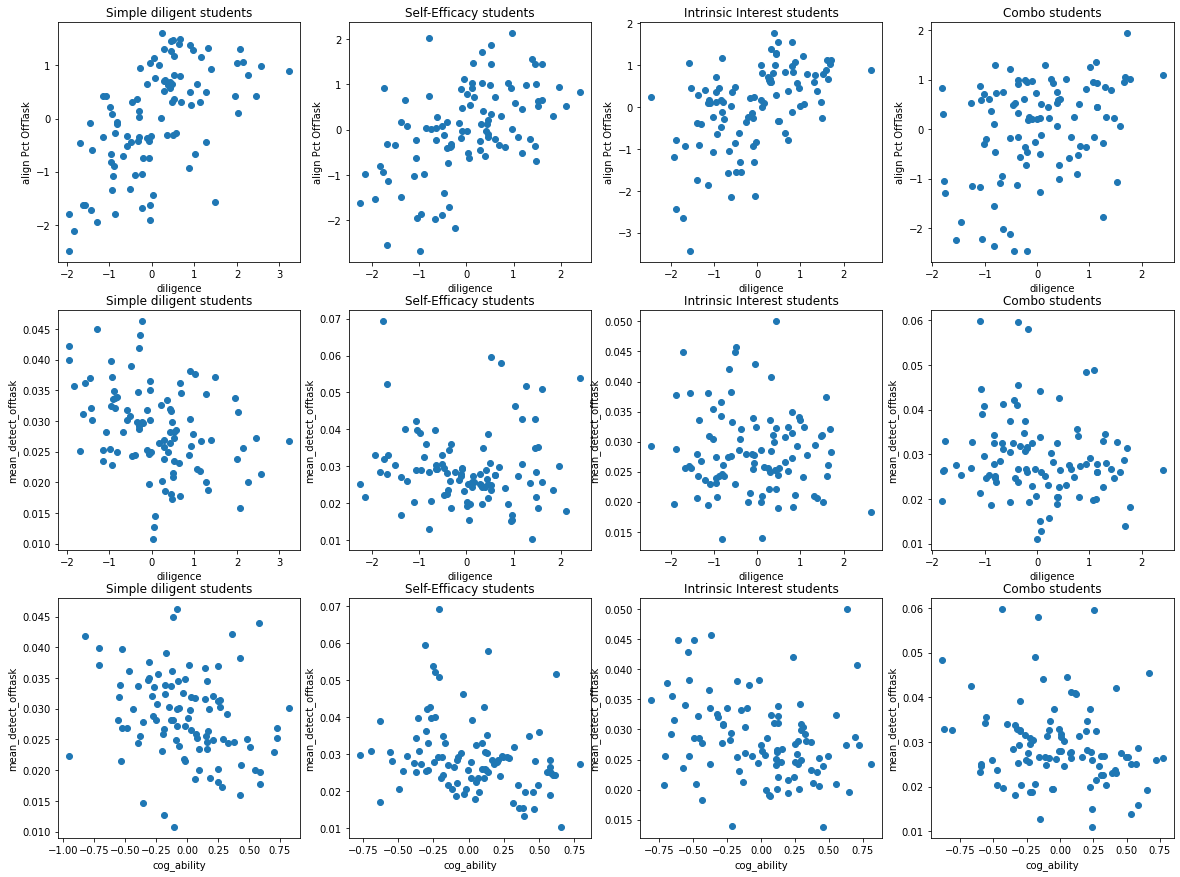

In [73]:
n = len(batch_descs)
plt.figure(figsize=(5*n,15))

for i, desc in enumerate(batch_descs):
    logger.info(f"Comparing student sim: {desc}")
    ss = stu_stats[desc]

    xcol = "diligence"
    ycol = "align Pct OffTask"
    X = ss[xcol]
    Y = ss[ycol]
    corr, pval = pearsonr(X,Y)
    logger.info(f"Correlation with Diligence: R = {corr}\t pval = {pval}")

    plt.subplot(3,n,i+1)
    plt.scatter(X, Y)
    plt.title(desc)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    
    xcol = "diligence"
    ycol = "mean_detect_offtask"
    X = ss[xcol]
    Y = ss[ycol]
    corr, pval = pearsonr(X,Y)
    logger.info(f"Correlation with Diligence: R = {corr}\t pval = {pval}")

    plt.subplot(3,n,n+i+1)
    plt.scatter(X, Y)
    plt.title(desc)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    
    xcol = "cog_ability"
    ycol = "mean_detect_offtask"
    X = ss[xcol]
    corr, pval = pearsonr(X,Y)
    logger.info(f"Correlation with Cog Ability: R = {corr}\t pval = {pval}")

    plt.subplot(3,n,2*n+i+1)
    plt.scatter(X, Y)
    plt.title(desc)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
plt.show()
    
    

### M2: Total Time

INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Correlation with Diligence: R = 0.6922095071141917	 pval = 1.5105575749694013e-15
INFO:analytics.session:Correlation with Diligence: R = 0.5409120713556189	 pval = 6.254080780839429e-09
INFO:analytics.session:Correlation with Cog Ability: R = 0.10197587288150062	 pval = 0.3127001050341241
INFO:analytics.session:Comparing student sim: Self-Efficacy students
INFO:analytics.session:Correlation with Diligence: R = 0.6264602608311409	 pval = 3.1424815452697223e-12
INFO:analytics.session:Correlation with Diligence: R = 0.5359715837869713	 pval = 9.106447313336746e-09
INFO:analytics.session:Correlation with Cog Ability: R = 0.06690972102774626	 pval = 0.5083386493748859
INFO:analytics.session:Comparing student sim: Intrinsic Interest students
INFO:analytics.session:Correlation with Diligence: R = 0.5637722209320831	 pval = 1.013195279617504e-09
INFO:analytics.session:Correlation with Diligence: R = 0

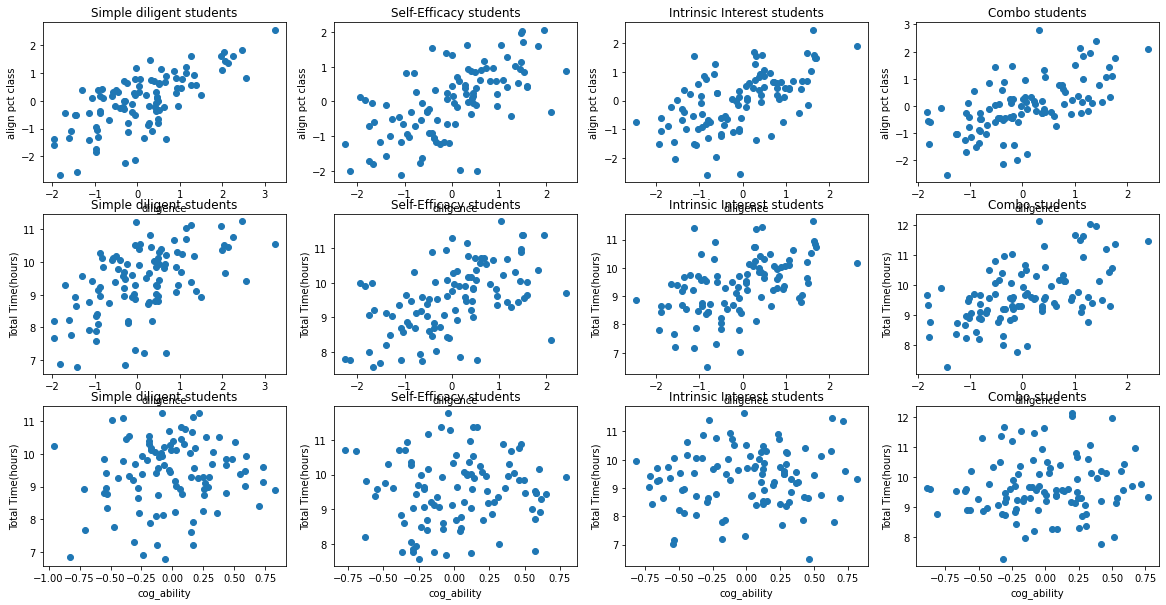

In [69]:
n = len(batch_descs)
plt.figure(figsize=(5*n,10))

for i, desc in enumerate(batch_descs):
    logger.info(f"Comparing student sim: {desc}")
    ss = stu_stats[desc]
    
    xcol = "diligence"
    ycol = "align pct class"
    X = ss[xcol]
    Y = ss[ycol]
    corr, pval = pearsonr(X,Y)
    logger.info(f"Correlation with Diligence: R = {corr}\t pval = {pval}")

    plt.subplot(3,n,i+1)
    plt.scatter(X, Y)
    plt.title(desc)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    
    xcol = "diligence"
    ycol = "Total Time(hours)"
    X = ss[xcol]
    Y = ss[ycol]
    corr, pval = pearsonr(X,Y)
    logger.info(f"Correlation with Diligence: R = {corr}\t pval = {pval}")

    plt.subplot(3,n,n+i+1)
    plt.scatter(X, Y)
    plt.title(desc)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    
    xcol = "cog_ability"
    X = ss[xcol]
    corr, pval = pearsonr(X,Y)
    logger.info(f"Correlation with Cog Ability: R = {corr}\t pval = {pval}")

    plt.subplot(3,n,2*n+i+1)
    plt.scatter(X, Y)
    plt.title(desc)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
plt.show()
    
    

### M3: Time-on-task

INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:R = 0.49693135184388204	 pval = 1.449351186113904e-07
INFO:analytics.session:Correlation with Cog Ability: R = -0.11543831818121227	 pval = 0.2527489159884905
INFO:analytics.session:Comparing student sim: Self-Efficacy students
INFO:analytics.session:R = 0.4988200005402458	 pval = 1.2777103090323376e-07
INFO:analytics.session:Correlation with Cog Ability: R = -0.14361710986999612	 pval = 0.1540080065746774
INFO:analytics.session:Comparing student sim: Intrinsic Interest students
INFO:analytics.session:R = 0.5447933841213632	 pval = 4.635583857085171e-09
INFO:analytics.session:Correlation with Cog Ability: R = -0.10725525986687591	 pval = 0.2881742457567982
INFO:analytics.session:Comparing student sim: Combo students
INFO:analytics.session:R = 0.3881895957290875	 pval = 6.585969622413564e-05
INFO:analytics.session:Correlation with Cog Ability: R = -0.11555520313772892	 pval = 0.2522655729924858

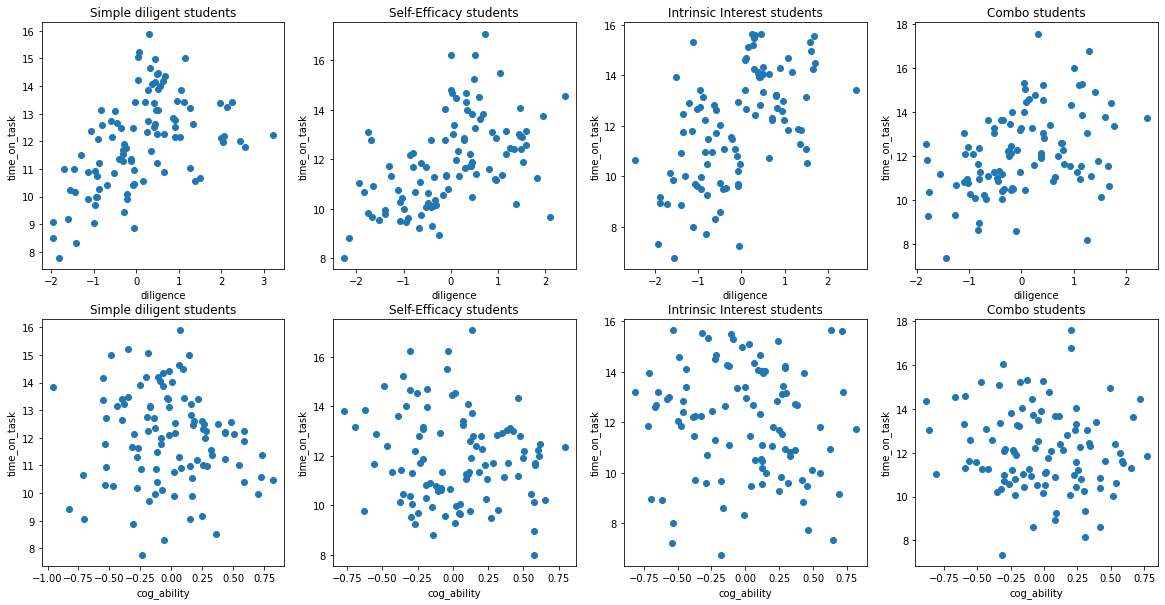

In [44]:
n = len(batch_descs)
plt.figure(figsize=(5*n,10))

for i, desc in enumerate(batch_descs):
    logger.info(f"Comparing student sim: {desc}")
    ss = stu_stats[desc]
    xcol = "diligence"
    ycol = "time_on_task"
    X = ss[xcol]
    Y = ss[ycol]
    corr, pval = pearsonr(X,Y)
    logger.info(f"R = {corr}\t pval = {pval}")

    plt.subplot(2,n,i+1)
    plt.scatter(X, Y)
    plt.title(desc)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    
    xcol = "cog_ability"
    X = ss[xcol]
    corr, pval = pearsonr(X,Y)
    logger.info(f"Correlation with Cog Ability: R = {corr}\t pval = {pval}")

    plt.subplot(2,n,n+i+1)
    plt.scatter(X, Y)
    plt.title(desc)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
plt.show()
    
    

### M4: Start Speed

INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:R = 0.5254293295108524	 pval = 1.990329249788344e-08
INFO:analytics.session:Correlation with Cog Ability: R = 0.05172853380801065	 pval = 0.6092641021855812
INFO:analytics.session:Comparing student sim: Self-Efficacy students
INFO:analytics.session:R = 0.5833631168717842	 pval = 1.900208003226018e-10
INFO:analytics.session:Correlation with Cog Ability: R = 0.16886135214585854	 pval = 0.0930611071114908
INFO:analytics.session:Comparing student sim: Intrinsic Interest students
INFO:analytics.session:R = 0.474094256125641	 pval = 6.276151631421287e-07
INFO:analytics.session:Correlation with Cog Ability: R = 0.09261940561511021	 pval = 0.3593934094605914
INFO:analytics.session:Comparing student sim: Combo students
INFO:analytics.session:R = 0.41063017751261943	 pval = 2.201540618375641e-05
INFO:analytics.session:Correlation with Cog Ability: R = 0.015238481434367108	 pval = 0.8803877583373824


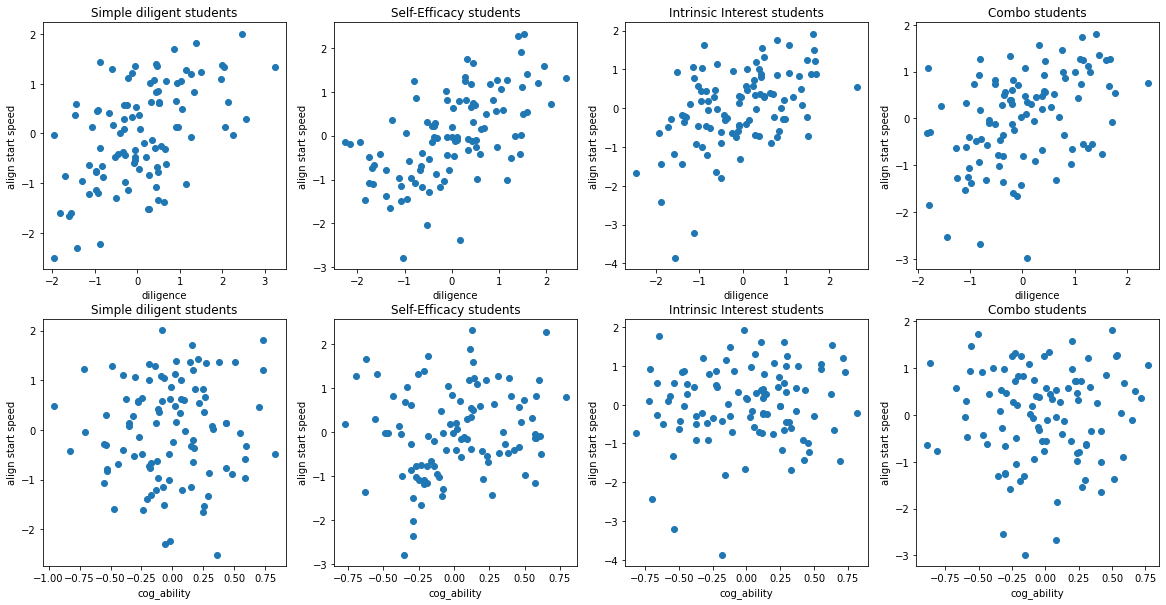

In [70]:
n = len(batch_descs)
plt.figure(figsize=(5*n,10))

for i, desc in enumerate(batch_descs):
    logger.info(f"Comparing student sim: {desc}")
    ss = stu_stats[desc]
    xcol = "diligence"
    ycol = "align start speed"
    X = ss[xcol]
    Y = ss[ycol]
    corr, pval = pearsonr(X,Y)
    logger.info(f"R = {corr}\t pval = {pval}")

    plt.subplot(2,n,i+1)
    plt.scatter(X, Y)
    plt.title(desc)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    
    xcol = "cog_ability"
    X = ss[xcol]
    corr, pval = pearsonr(X,Y)
    logger.info(f"Correlation with Cog Ability: R = {corr}\t pval = {pval}")

    plt.subplot(2,n,n+i+1)
    plt.scatter(X, Y)
    plt.title(desc)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
plt.show()
    
    

### M5: Early Finish

INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:R = 0.6292379339324312	 pval = 2.360041561312668e-12
INFO:analytics.session:Correlation with Cog Ability: R = 0.02846182940594178	 pval = 0.7786360907782544
INFO:analytics.session:Comparing student sim: Self-Efficacy students
INFO:analytics.session:R = 0.5219449500255059	 pval = 2.562337811350274e-08
INFO:analytics.session:Correlation with Cog Ability: R = 0.06771334611548732	 pval = 0.5032473001052649
INFO:analytics.session:Comparing student sim: Intrinsic Interest students
INFO:analytics.session:R = 0.3785154173537094	 pval = 0.00010314187019201771
INFO:analytics.session:Correlation with Cog Ability: R = -0.06181114993797282	 pval = 0.5412493039049281
INFO:analytics.session:Comparing student sim: Combo students
INFO:analytics.session:R = 0.5239844665809605	 pval = 2.210897824163054e-08
INFO:analytics.session:Correlation with Cog Ability: R = -0.014851393312708516	 pval = 0.8834044835608018


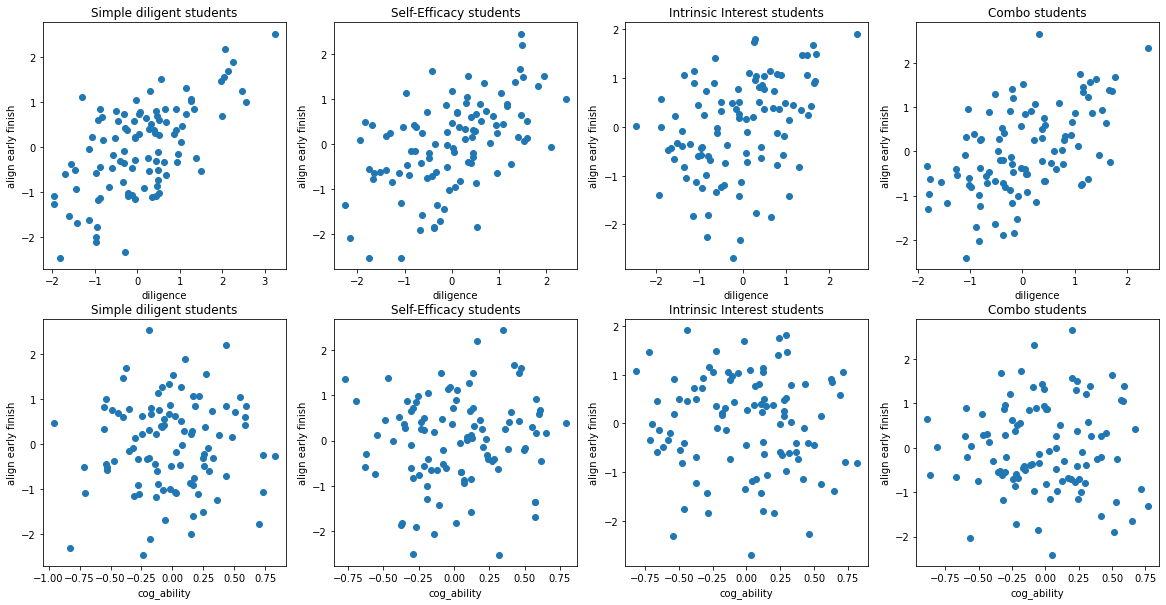

In [71]:
n = len(batch_descs)
plt.figure(figsize=(5*n,10))

for i, desc in enumerate(batch_descs):
    logger.info(f"Comparing student sim: {desc}")
    ss = stu_stats[desc]
    xcol = "diligence"
    ycol = "align early finish"
    X = ss[xcol]
    Y = ss[ycol]
    corr, pval = pearsonr(X,Y)
    logger.info(f"R = {corr}\t pval = {pval}")

    plt.subplot(2,n,i+1)
    plt.scatter(X, Y)
    plt.title(desc)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    
    xcol = "cog_ability"
    X = ss[xcol]
    corr, pval = pearsonr(X,Y)
    logger.info(f"Correlation with Cog Ability: R = {corr}\t pval = {pval}")

    plt.subplot(2,n,n+i+1)
    plt.scatter(X, Y)
    plt.title(desc)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
plt.show()
    
    

### Multi-Diligence Measures

In [47]:
from itertools import combinations 


#### Measures with noise

INFO:analytics.session:Comparing models with columns: ('Total Time(hours)', 'mean_detect_offtask')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.49497500126256266
INFO:analytics.session:EigenValues: [1.35505391 0.64494609]
INFO:analytics.session:Factor Loadings: [[-0.59586401]
 [ 0.59586401]]
INFO:analytics.session:Factor Variance: (array([0.71010783]), array([0.35505391]), array([0.35505391]))
INFO:analytics.session:Factor loadings: Total Time(hours)     -0.595864
mean_detect_offtask    0.595864
dtype: float64
INFO:analytics.session:(100,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = -0.5420452992852471	 pval = 5.732716895732604e-09
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Self-Efficacy

Created 6 Combinations of length 2


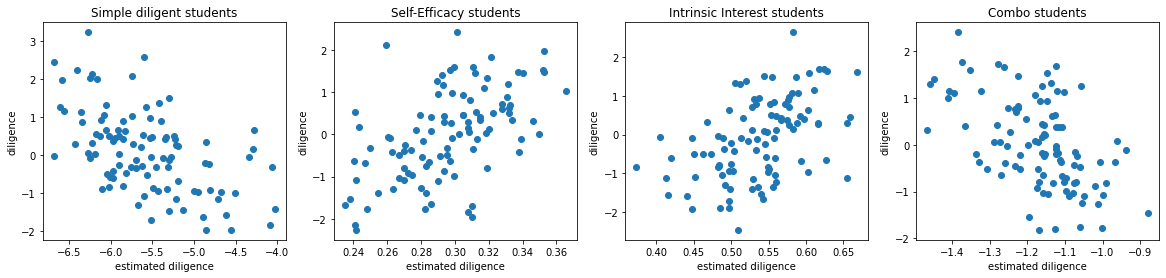

INFO:analytics.session:Comparing models with columns: ('Total Time(hours)', 'start speed')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.4949750012625625
INFO:analytics.session:EigenValues: [1.48873569 0.51126431]
INFO:analytics.session:Factor Loadings: [[-0.69909634]
 [ 0.69909634]]
INFO:analytics.session:Factor Variance: (array([0.97747138]), array([0.48873569]), array([0.48873569]))
INFO:analytics.session:Factor loadings: Total Time(hours)   -0.699096
start speed          0.699096
dtype: float64
INFO:analytics.session:(100,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = -0.6178659959009012	 pval = 7.486931048071571e-12
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Self-Efficacy students
INF

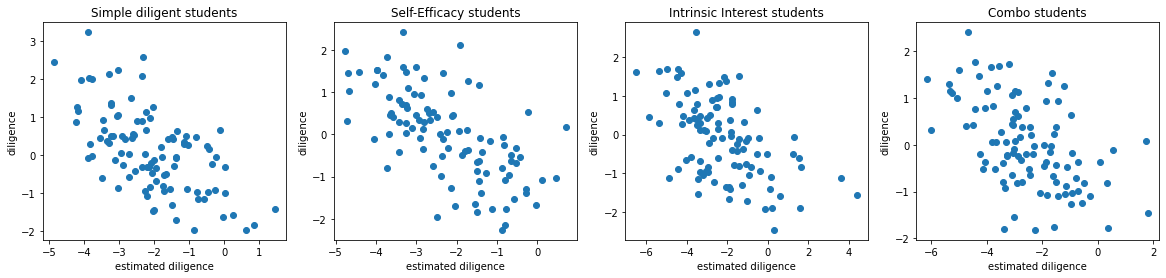

INFO:analytics.session:Comparing models with columns: ('Total Time(hours)', 'early finish')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.4949750012625624
INFO:analytics.session:EigenValues: [1.78304825 0.21695175]
INFO:analytics.session:Factor Loadings: [[-0.88490014]
 [ 0.88490014]]
INFO:analytics.session:Factor Variance: (array([1.56609651]), array([0.78304825]), array([0.78304825]))
INFO:analytics.session:Factor loadings: Total Time(hours)   -0.8849
early finish         0.8849
dtype: float64
INFO:analytics.session:(100,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = -0.6320531823675021	 pval = 1.7603940148032426e-12
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Self-Efficacy students
INFO:

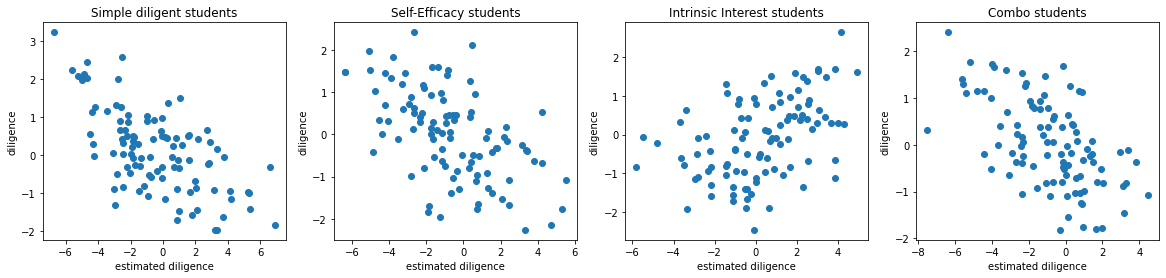

INFO:analytics.session:Comparing models with columns: ('mean_detect_offtask', 'start speed')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.49497500126256283
INFO:analytics.session:EigenValues: [1.17558779 0.82441221]
INFO:analytics.session:Factor Loadings: [[0.41903197]
 [0.41903197]]
INFO:analytics.session:Factor Variance: (array([0.35117558]), array([0.17558779]), array([0.17558779]))
INFO:analytics.session:Factor loadings: mean_detect_offtask    0.419032
start speed            0.419032
dtype: float64
INFO:analytics.session:(100,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = -0.5272079839777009	 pval = 1.747604211971769e-08
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Self-Efficacy student

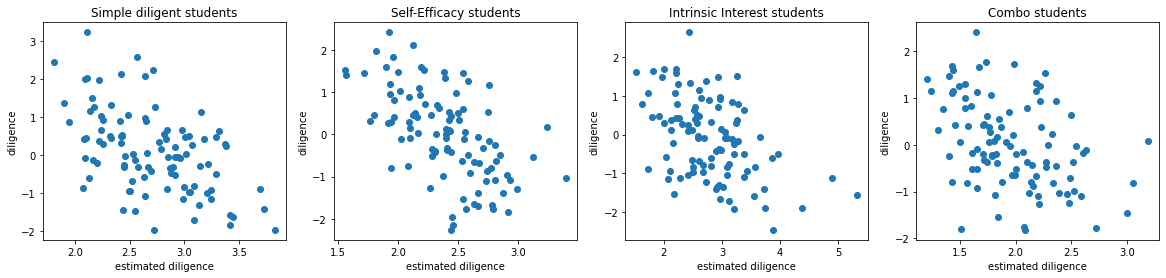

INFO:analytics.session:Comparing models with columns: ('mean_detect_offtask', 'early finish')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.49497500126256255
INFO:analytics.session:EigenValues: [1.26900956 0.73099044]
INFO:analytics.session:Factor Loadings: [[-0.51866132]
 [-0.51866132]]
INFO:analytics.session:Factor Variance: (array([0.53801913]), array([0.26900957]), array([0.26900957]))
INFO:analytics.session:Factor loadings: mean_detect_offtask   -0.518661
early finish          -0.518661
dtype: float64
INFO:analytics.session:(100,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = 0.6298079670897633	 pval = 2.224570023839871e-12
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Self-Efficacy stude

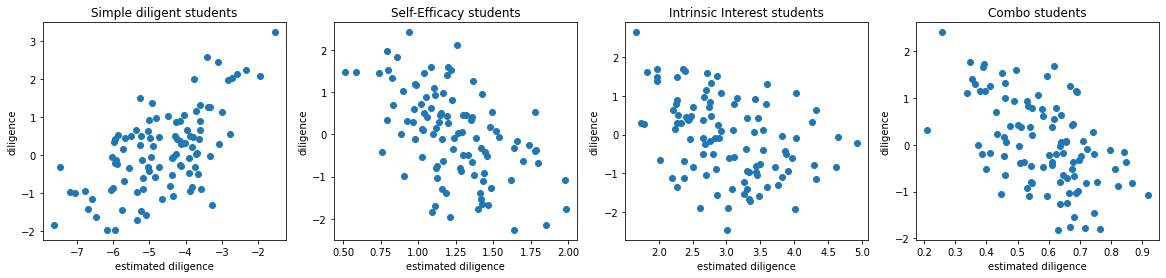

INFO:analytics.session:Comparing models with columns: ('start speed', 'early finish')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.49497500126256283
INFO:analytics.session:EigenValues: [1.26102745 0.73897255]
INFO:analytics.session:Factor Loadings: [[0.51090845]
 [0.51090845]]
INFO:analytics.session:Factor Variance: (array([0.5220549]), array([0.26102745]), array([0.26102745]))
INFO:analytics.session:Factor loadings: start speed     0.510908
early finish    0.510908
dtype: float64
INFO:analytics.session:(100,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = -0.7220037997884439	 pval = 2.3246228407141588e-17
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Self-Efficacy students
INFO:analytics.sess

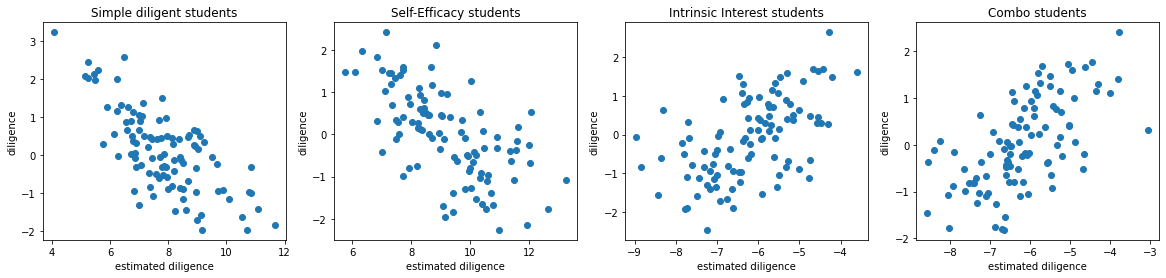

INFO:analytics.session:Comparing models with columns: ('Total Time(hours)', 'mean_detect_offtask', 'start speed')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.5534760940802351
INFO:analytics.session:EigenValues: [1.69527262 0.83458309 0.47014429]
INFO:analytics.session:Factor Loadings: [[-0.99410777]
 [ 0.35715751]
 [ 0.49163312]]
INFO:analytics.session:Factor Variance: (array([1.35751487]), array([0.45250496]), array([0.45250496]))
INFO:analytics.session:Factor loadings: Total Time(hours)     -0.994108
mean_detect_offtask    0.357158
start speed            0.491633
dtype: float64
INFO:analytics.session:(100,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = -0.6100197719838701	 pval = 1.616753361790794e-11
INFO:analytics.session:***************************************

Created 4 Combinations of length 3


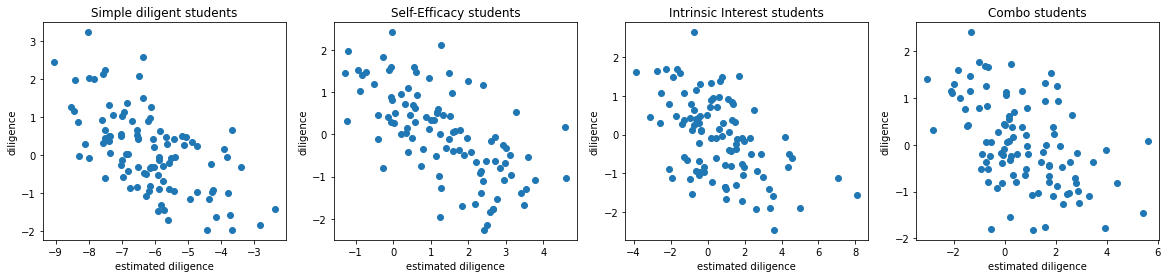

INFO:analytics.session:Comparing models with columns: ('Total Time(hours)', 'mean_detect_offtask', 'early finish')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.5535892841884258
INFO:analytics.session:EigenValues: [1.98180851 0.80680874 0.21138275]
INFO:analytics.session:Factor Loadings: [[-0.99901352]
 [ 0.35109229]
 [ 0.7818851 ]]
INFO:analytics.session:Factor Variance: (array([1.73263812]), array([0.57754604]), array([0.57754604]))
INFO:analytics.session:Factor loadings: Total Time(hours)     -0.999014
mean_detect_offtask    0.351092
early finish           0.781885
dtype: float64
INFO:analytics.session:(100,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = -0.6299079086312386	 pval = 2.201605034944963e-12
INFO:analytics.session:**************************************

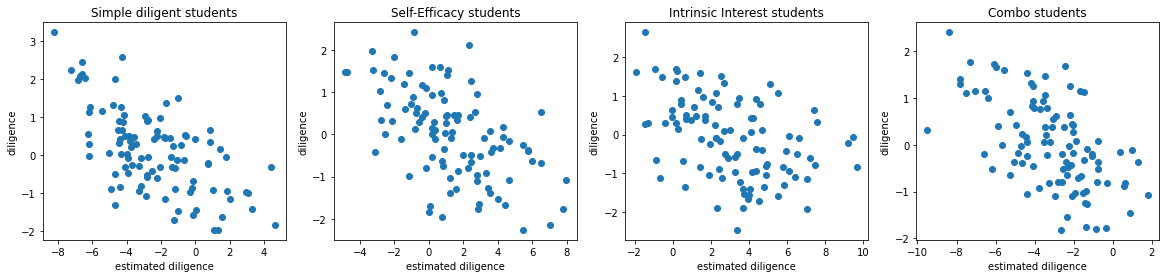

INFO:analytics.session:Comparing models with columns: ('Total Time(hours)', 'start speed', 'early finish')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.5060413408815292
INFO:analytics.session:EigenValues: [2.05347658 0.76957705 0.17694636]
INFO:analytics.session:Factor Loadings: [[-1.01699938]
 [ 0.43545525]
 [ 0.74354004]]
INFO:analytics.session:Factor Variance: (array([1.7767608]), array([0.5922536]), array([0.5922536]))
INFO:analytics.session:Factor loadings: Total Time(hours)   -1.016999
start speed          0.435455
early finish         0.743540
dtype: float64
INFO:analytics.session:(100,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = -0.6694421532568368	 pval = 2.651147151986923e-14
INFO:analytics.session:***************************************************
INF

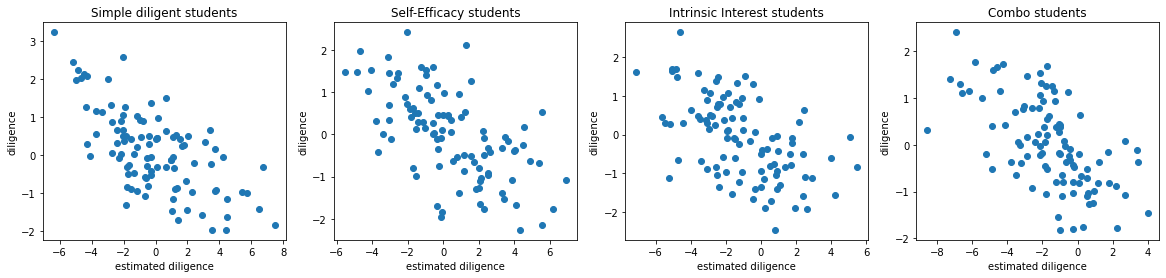

INFO:analytics.session:Comparing models with columns: ('mean_detect_offtask', 'start speed', 'early finish')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.5855931722048824
INFO:analytics.session:EigenValues: [1.47275102 0.82455398 0.702695  ]
INFO:analytics.session:Factor Loadings: [[-0.42539146]
 [-0.41276916]
 [-0.63238121]]
INFO:analytics.session:Factor Variance: (array([0.75124227]), array([0.25041409]), array([0.25041409]))
INFO:analytics.session:Factor loadings: mean_detect_offtask   -0.425391
start speed           -0.412769
early finish          -0.632381
dtype: float64
INFO:analytics.session:(100,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = 0.7040054949932724	 pval = 3.078262497050404e-16
INFO:analytics.session:*********************************************

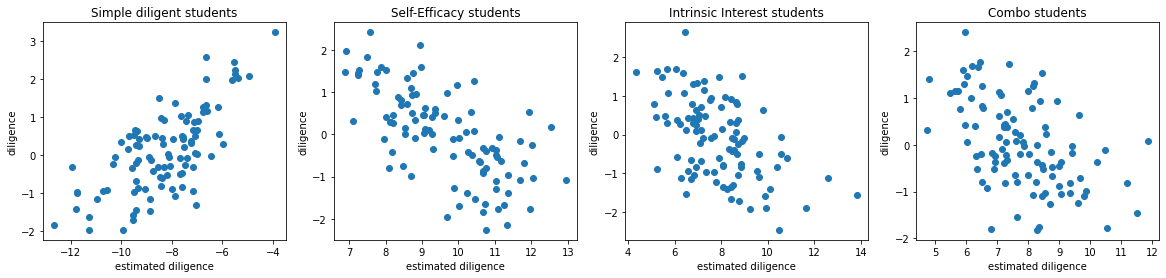

INFO:analytics.session:Comparing models with columns: ('Total Time(hours)', 'mean_detect_offtask', 'start speed', 'early finish')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.5577112963619932
INFO:analytics.session:EigenValues: [2.23622661 0.83484882 0.75576409 0.17316047]
INFO:analytics.session:Factor Loadings: [[-1.01513629]
 [ 0.35884006]
 [ 0.43986472]
 [ 0.74385526]]
INFO:analytics.session:Factor Variance: (array([1.9060695]), array([0.47651738]), array([0.47651738]))
INFO:analytics.session:Factor loadings: Total Time(hours)     -1.015136
mean_detect_offtask    0.358840
start speed            0.439865
early finish           0.743855
dtype: float64
INFO:analytics.session:(100,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = -0.6699311902071664	 pval = 2.499520519

Created 1 Combinations of length 4


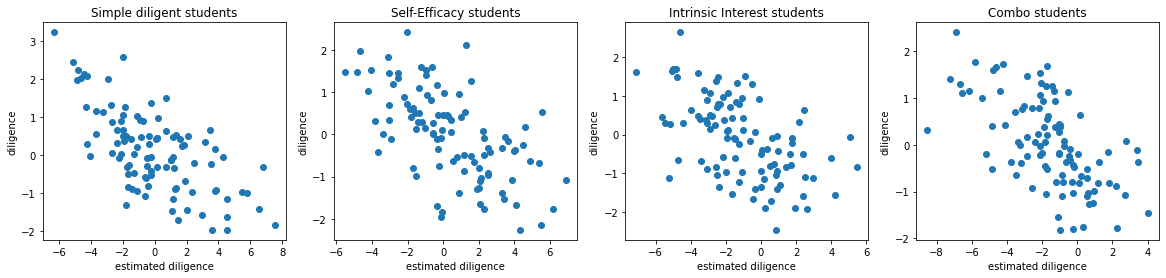

In [48]:
dil_factors = ['Total Time(hours)', 'mean_detect_offtask', 'start speed', 'early finish']


for r in range(2,len(dil_factors)+1):
    dil_combos = list(combinations(dil_factors, r))
    print(f"Created {len(dil_combos)} Combinations of length {r}")
    for combo in dil_combos:
        n = len(batch_descs)
        plt.figure(figsize=(5*n,4))
        logger.info(f"Comparing models with columns: {combo}")
        for i, desc in enumerate(batch_descs):
            logger.info("***************************************************")
            logger.info(f"Comparing student sim: {desc}")
            ss = stu_stats[desc]
        #    cog_cols = ['accuracy', 'err_on_1_opp', 'avg_prac_opp', 'final-sim total mastery']

            xcols = combo
            ycol = "diligence"
            #Factor analysis
            df = ss.loc[:,xcols]
            kmo_all, kmo_model = calculate_kmo(df)
            logger.info(f"Overall Model Kaiser-Meyer-Olkin (KMO) Test: {kmo_model}")
            fa = FactorAnalyzer(rotation=None,  n_factors=1)
            fa.fit(df)
            # Check Eigenvalues
            ev, v = fa.get_eigenvalues()
            logger.info(f"EigenValues: {ev}")
            logger.info(f"Factor Loadings: {fa.loadings_}")
            logger.info(f"Factor Variance: {fa.get_factor_variance()}")

            loadings = pd.Series([x[0] for x in fa.loadings_], index=df.columns)
            logger.info(f"Factor loadings: {loadings}")
            X = df.mul(loadings).apply('sum', axis=1)
            logger.info(X.shape)
            Y = ss[ycol]
            corr, pval = pearsonr(X,Y)
            logger.info("******************* Pearson ********************")
            logger.info(f"R = {corr}\t pval = {pval}")

            plt.subplot(1,n,i+1)
            plt.scatter(X, Y)
            plt.title(desc)
            plt.xlabel("estimated diligence")
            plt.ylabel(ycol)
        plt.show()

#### Measures with no noise

INFO:analytics.session:Comparing models with columns: ('pct class', 'Pct OffTask')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
/rdata/Sandbox/MotivSim/notebooks/jvenv/lib/python3.8/site-packages/factor_analyzer/utils.py:248: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.49497500126256255
INFO:analytics.session:EigenValues: [1.37696048 0.62303952]
INFO:analytics.session:Factor Loadings: [[-0.61397108]
 [ 0.61397108]]
INFO:analytics.session:Factor Variance: (array([0.75392098]), array([0.37696049]), array([0.37696049]))
INFO:analytics.session:Factor loadings: pct class     -0.613971
Pct OffTask    0.613971
dtype: float64

Created 6 Combinations of length 2


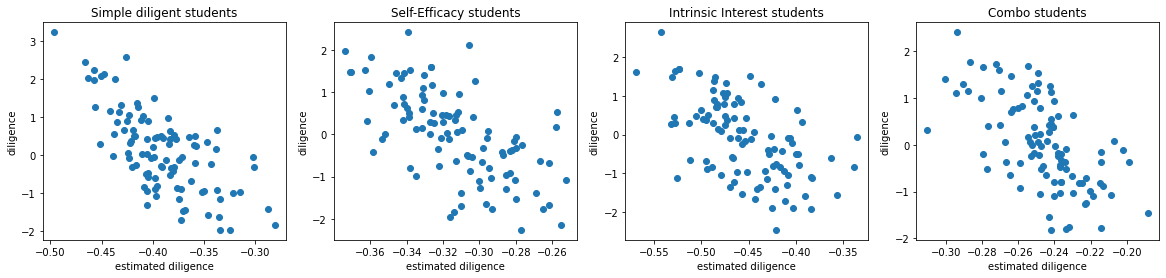

INFO:analytics.session:Comparing models with columns: ('pct class', 'start speed')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.4949750012625629
INFO:analytics.session:EigenValues: [1.57584246 0.42415754]
INFO:analytics.session:Factor Loadings: [[-0.75884285]
 [ 0.75884284]]
INFO:analytics.session:Factor Variance: (array([1.15168493]), array([0.57584246]), array([0.57584246]))
INFO:analytics.session:Factor loadings: pct class     -0.758843
start speed    0.758843
dtype: float64
INFO:analytics.session:(100,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = -0.5483801632620069	 pval = 3.5029741583790555e-09
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Self-Efficacy students
INFO:analytics.session

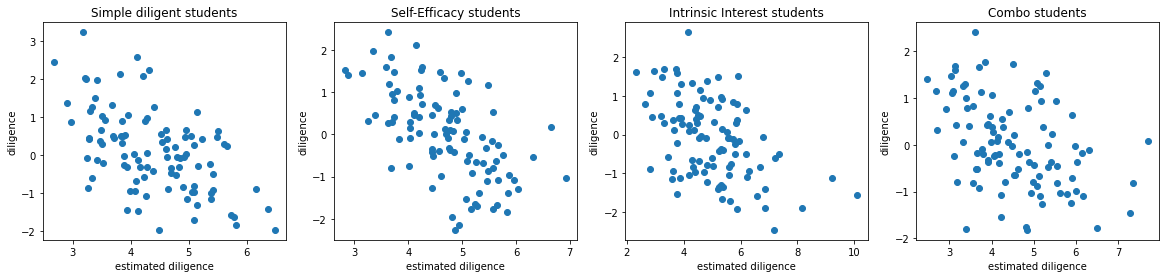

INFO:analytics.session:Comparing models with columns: ('pct class', 'early finish')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.4949750012625626
INFO:analytics.session:EigenValues: [1.90283867 0.09716133]
INFO:analytics.session:Factor Loadings: [[-0.95017823]
 [ 0.95017823]]
INFO:analytics.session:Factor Variance: (array([1.80567734]), array([0.90283867]), array([0.90283867]))
INFO:analytics.session:Factor loadings: pct class      -0.950178
early finish    0.950178
dtype: float64
INFO:analytics.session:(100,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = -0.6326109606019181	 pval = 1.6604752976577633e-12
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Self-Efficacy students
INFO:analytics.sess

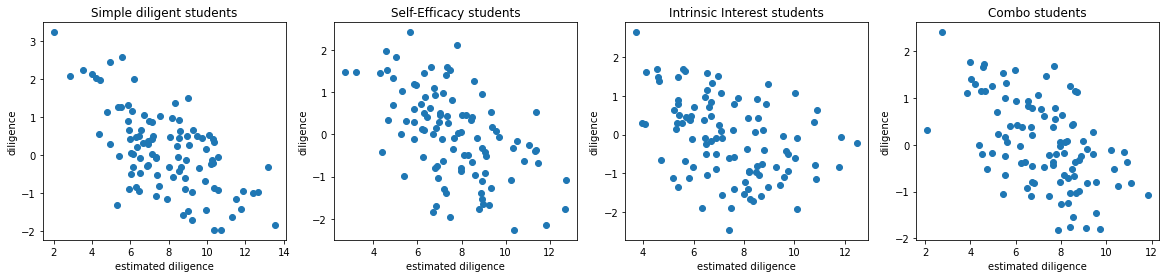

INFO:analytics.session:Comparing models with columns: ('Pct OffTask', 'start speed')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.4949750012625629
INFO:analytics.session:EigenValues: [1.27893442 0.72106558]
INFO:analytics.session:Factor Loadings: [[-0.52814243]
 [-0.52814243]]
INFO:analytics.session:Factor Variance: (array([0.55786885]), array([0.27893442]), array([0.27893442]))
INFO:analytics.session:Factor loadings: Pct OffTask   -0.528142
start speed   -0.528142
dtype: float64
INFO:analytics.session:(100,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = 0.5261077337274396	 pval = 1.8941756798870158e-08
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Self-Efficacy students
INFO:analytics.sessio

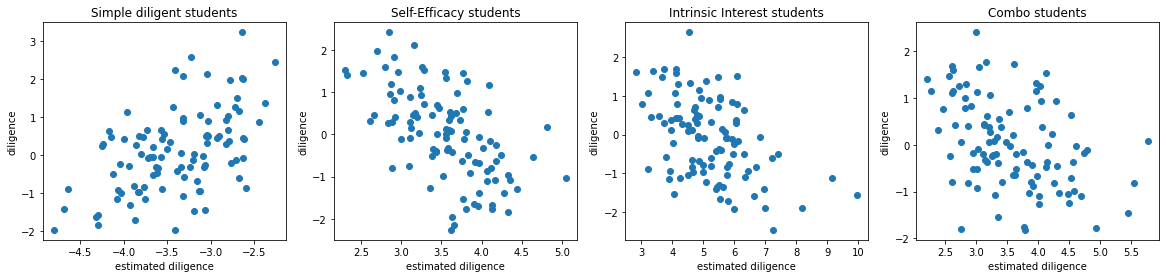

INFO:analytics.session:Comparing models with columns: ('Pct OffTask', 'early finish')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.49497500126256244
INFO:analytics.session:EigenValues: [1.32899795 0.67100205]
INFO:analytics.session:Factor Loadings: [[0.57358343]
 [0.57358343]]
INFO:analytics.session:Factor Variance: (array([0.6579959]), array([0.32899795]), array([0.32899795]))
INFO:analytics.session:Factor loadings: Pct OffTask     0.573583
early finish    0.573583
dtype: float64
INFO:analytics.session:(100,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = -0.6295011895925937	 pval = 2.2965161074315616e-12
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Self-Efficacy students
INFO:analytics.sess

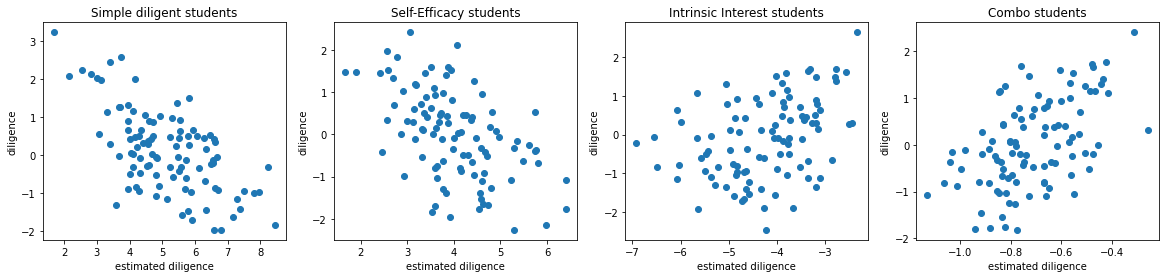

INFO:analytics.session:Comparing models with columns: ('start speed', 'early finish')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.49497500126256283
INFO:analytics.session:EigenValues: [1.26102745 0.73897255]
INFO:analytics.session:Factor Loadings: [[0.51090845]
 [0.51090845]]
INFO:analytics.session:Factor Variance: (array([0.5220549]), array([0.26102745]), array([0.26102745]))
INFO:analytics.session:Factor loadings: start speed     0.510908
early finish    0.510908
dtype: float64
INFO:analytics.session:(100,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = -0.7220037997884439	 pval = 2.3246228407141588e-17
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Self-Efficacy students
INFO:analytics.sess

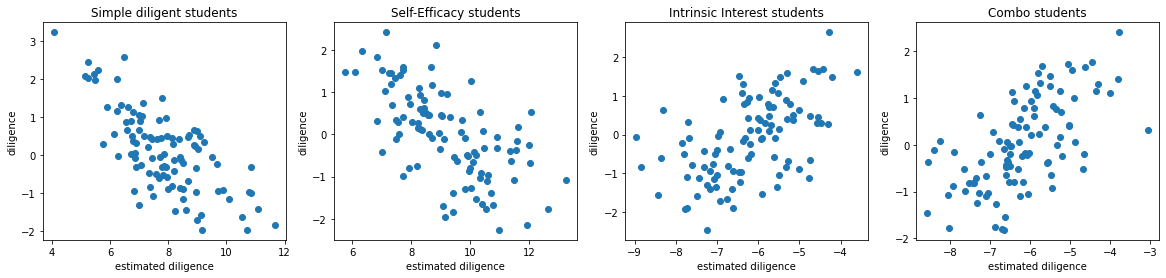

INFO:analytics.session:Comparing models with columns: ('pct class', 'Pct OffTask', 'start speed')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
/rdata/Sandbox/MotivSim/notebooks/jvenv/lib/python3.8/site-packages/factor_analyzer/utils.py:248: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.5984765128888675
INFO:analytics.session:EigenValues: [1.83461968 0.75314736 0.41223296]
INFO:analytics.session:Factor Loadings: [[ 0.88216221]
 [-0.42731403]
 [-0.65276235]]
INFO:analytics.session:Factor Variance: (array([1.38690612]), array([0.46230204]), array([0.46230204]))
INFO:analytics.session:Factor loadings: pct class      0.88216

Created 4 Combinations of length 3


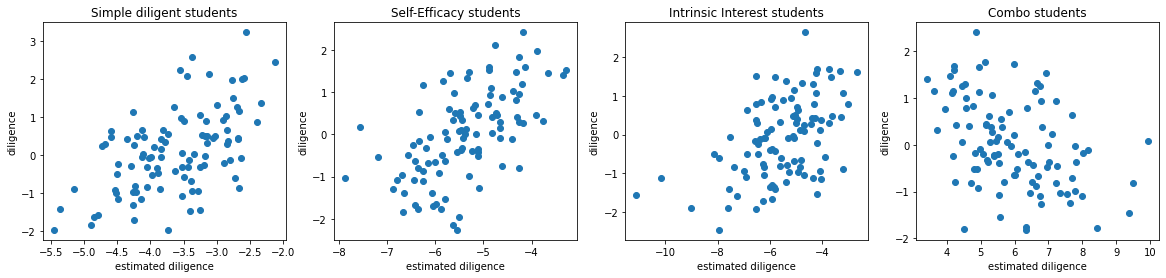

INFO:analytics.session:Comparing models with columns: ('pct class', 'Pct OffTask', 'early finish')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
/rdata/Sandbox/MotivSim/notebooks/jvenv/lib/python3.8/site-packages/factor_analyzer/utils.py:248: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.5564433444091621
INFO:analytics.session:EigenValues: [2.1245418  0.77979756 0.09566064]
INFO:analytics.session:Factor Loadings: [[-0.99950435]
 [ 0.37175609]
 [ 0.90106156]]
INFO:analytics.session:Factor Variance: (array([1.94912348]), array([0.64970783]), array([0.64970783]))
INFO:analytics.session:Factor loadings: pct class      -0.999

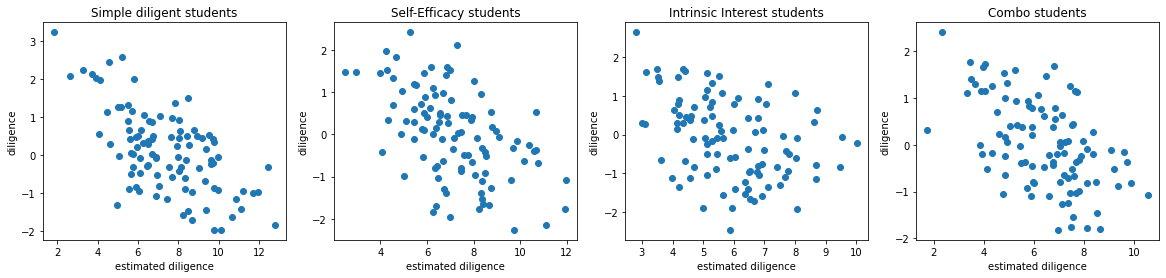

INFO:analytics.session:Comparing models with columns: ('pct class', 'start speed', 'early finish')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.35930697342137374
INFO:analytics.session:EigenValues: [2.20039582 0.76604647 0.03355772]
INFO:analytics.session:Factor Loadings: [[-1.03860355]
 [ 0.46430816]
 [ 0.81812954]]
INFO:analytics.session:Factor Variance: (array([1.96361534]), array([0.65453845]), array([0.65453845]))
INFO:analytics.session:Factor loadings: pct class      -1.038604
start speed     0.464308
early finish    0.818130
dtype: float64
INFO:analytics.session:(100,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = -0.6979959134122924	 pval = 6.989251119252123e-16
INFO:analytics.session:***************************************************
INFO:analytics.session

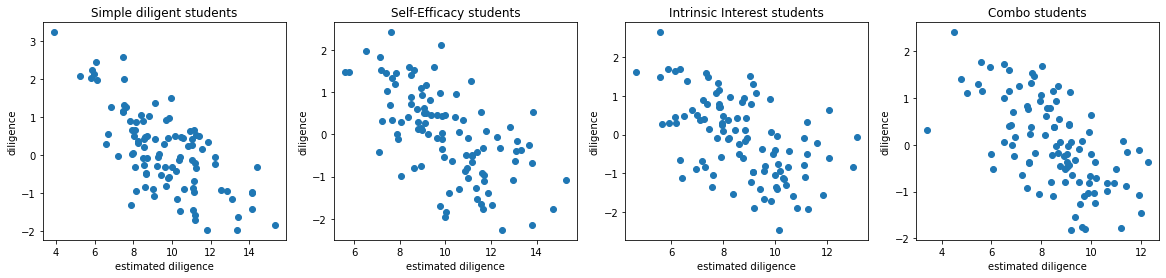

INFO:analytics.session:Comparing models with columns: ('Pct OffTask', 'start speed', 'early finish')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.6148382802894011
INFO:analytics.session:EigenValues: [1.58029175 0.75017167 0.66953658]
INFO:analytics.session:Factor Loadings: [[-0.59293198]
 [-0.47043258]
 [-0.55486683]]
INFO:analytics.session:Factor Variance: (array([0.88075233]), array([0.29358411]), array([0.29358411]))
INFO:analytics.session:Factor loadings: Pct OffTask    -0.592932
start speed    -0.470433
early finish   -0.554867
dtype: float64
INFO:analytics.session:(100,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = 0.7156428477159025	 pval = 5.925690286387892e-17
INFO:analytics.session:***************************************************
INFO:analytics.session

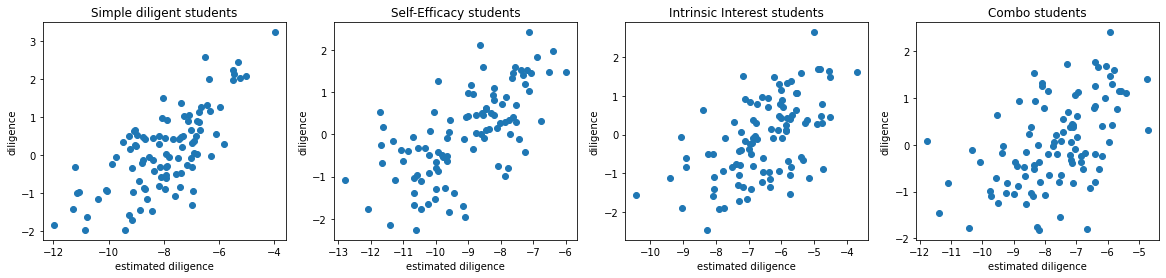

INFO:analytics.session:Comparing models with columns: ('pct class', 'Pct OffTask', 'start speed', 'early finish')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
/rdata/Sandbox/MotivSim/notebooks/jvenv/lib/python3.8/site-packages/factor_analyzer/utils.py:248: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.4168231402287093
INFO:analytics.session:EigenValues: [2.42953796 0.79256335 0.74434142 0.03355727]
INFO:analytics.session:Factor Loadings: [[-1.03170129]
 [ 0.40358741]
 [ 0.48642937]
 [ 0.81372179]]
INFO:analytics.session:Factor Variance: (array([2.12604703]), array([0.53151176]), array([0.53151176]))
INFO:analytics.sessi

Created 1 Combinations of length 4


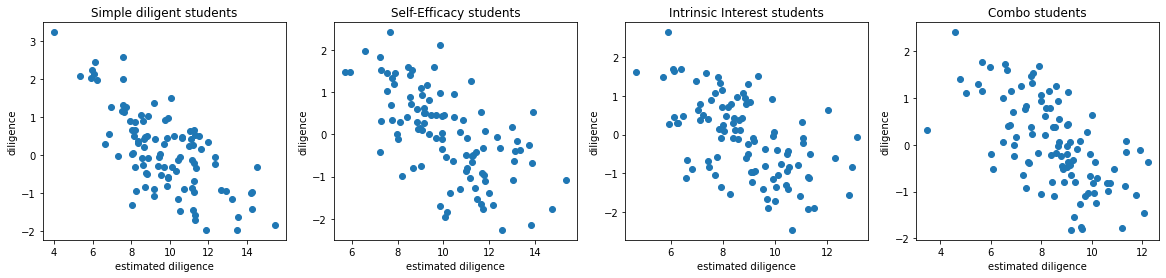

In [49]:
# dil_factors = ['Total Time(hours)', 'mean_detect_offtask', 'start speed', 'early finish']
dil_factors = ['pct class', 'Pct OffTask', 'start speed', 'early finish']

for r in range(2,len(dil_factors)+1):
    dil_combos = list(combinations(dil_factors, r))
    print(f"Created {len(dil_combos)} Combinations of length {r}")
    for combo in dil_combos:
        n = len(batch_descs)
        plt.figure(figsize=(5*n,4))
        logger.info(f"Comparing models with columns: {combo}")
        for i, desc in enumerate(batch_descs):
            logger.info("***************************************************")
            logger.info(f"Comparing student sim: {desc}")
            ss = stu_stats[desc]
        #    cog_cols = ['accuracy', 'err_on_1_opp', 'avg_prac_opp', 'final-sim total mastery']

            xcols = combo
            ycol = "diligence"
            #Factor analysis
            df = ss.loc[:,xcols]
            kmo_all, kmo_model = calculate_kmo(df)
            logger.info(f"Overall Model Kaiser-Meyer-Olkin (KMO) Test: {kmo_model}")
            fa = FactorAnalyzer(rotation=None,  n_factors=1)
            fa.fit(df)
            # Check Eigenvalues
            ev, v = fa.get_eigenvalues()
            logger.info(f"EigenValues: {ev}")
            logger.info(f"Factor Loadings: {fa.loadings_}")
            logger.info(f"Factor Variance: {fa.get_factor_variance()}")

            loadings = pd.Series([x[0] for x in fa.loadings_], index=df.columns)
            logger.info(f"Factor loadings: {loadings}")
            X = df.mul(loadings).apply('sum', axis=1)
            logger.info(X.shape)
            Y = ss[ycol]
            corr, pval = pearsonr(X,Y)
            logger.info("******************* Pearson ********************")
            logger.info(f"R = {corr}\t pval = {pval}")

            plt.subplot(1,n,i+1)
            plt.scatter(X, Y)
            plt.title(desc)
            plt.xlabel("estimated diligence")
            plt.ylabel(ycol)
        plt.show()

INFO:analytics.session:Comparing models with columns: ('align pct class', 'align Pct OffTask')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.49497500126256233
INFO:analytics.session:EigenValues: [1.37696048 0.62303952]
INFO:analytics.session:Factor Loadings: [[-0.61397108]
 [-0.61397108]]
INFO:analytics.session:Factor Variance: (array([0.75392097]), array([0.37696049]), array([0.37696049]))
INFO:analytics.session:Factor loadings: align pct class     -0.613971
align Pct OffTask   -0.613971
dtype: float64
INFO:analytics.session:(100,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = -0.7711454020973967	 pval = 6.281298593744296e-21
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Self-Efficacy student

Created 6 Combinations of length 2


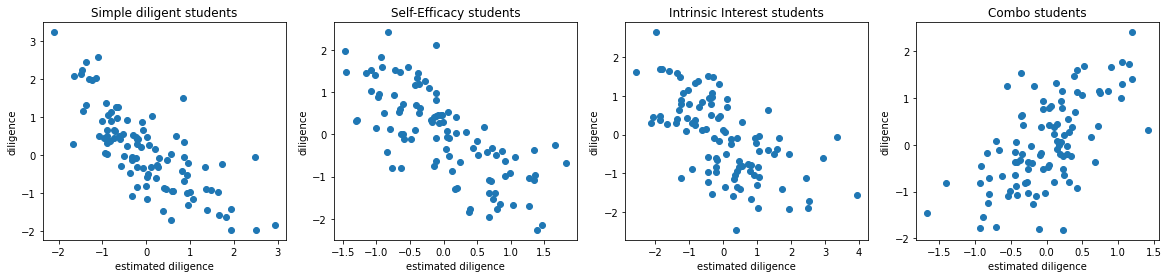

INFO:analytics.session:Comparing models with columns: ('align pct class', 'align start speed')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.49497500126256255
INFO:analytics.session:EigenValues: [1.57584246 0.42415754]
INFO:analytics.session:Factor Loadings: [[-0.75884285]
 [-0.75884285]]
INFO:analytics.session:Factor Variance: (array([1.15168493]), array([0.57584246]), array([0.57584246]))
INFO:analytics.session:Factor loadings: align pct class     -0.758843
align start speed   -0.758843
dtype: float64
INFO:analytics.session:(100,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = -0.6858783498630804	 pval = 3.439472973916216e-15
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Self-Efficacy student

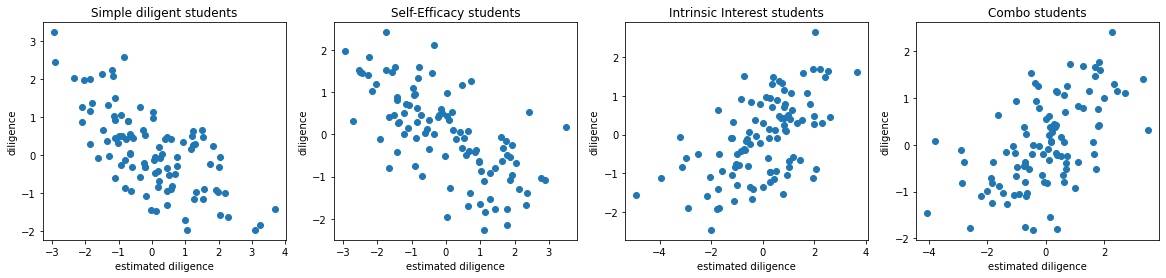

INFO:analytics.session:Comparing models with columns: ('align pct class', 'align early finish')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.49497500126256255
INFO:analytics.session:EigenValues: [1.90283867 0.09716133]
INFO:analytics.session:Factor Loadings: [[0.95017823]
 [0.95017823]]
INFO:analytics.session:Factor Variance: (array([1.80567734]), array([0.90283867]), array([0.90283867]))
INFO:analytics.session:Factor loadings: align pct class       0.950178
align early finish    0.950178
dtype: float64
INFO:analytics.session:(100,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = 0.6773824057653323	 pval = 1.0048229961013183e-14
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Self-Efficacy studen

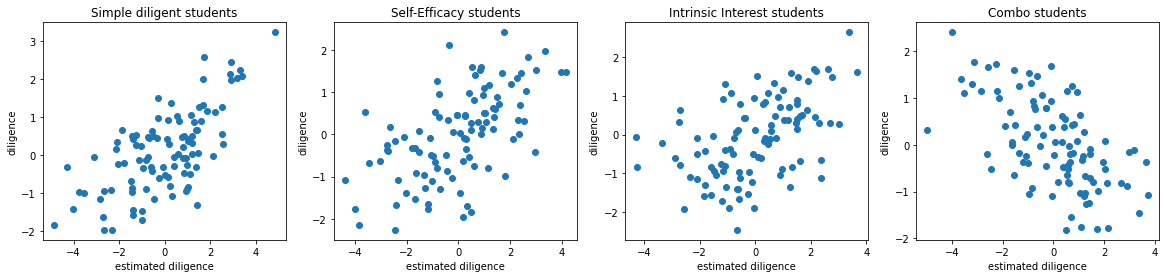

INFO:analytics.session:Comparing models with columns: ('align Pct OffTask', 'align start speed')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.49497500126256233
INFO:analytics.session:EigenValues: [1.27893442 0.72106558]
INFO:analytics.session:Factor Loadings: [[-0.52814243]
 [-0.52814243]]
INFO:analytics.session:Factor Variance: (array([0.55786885]), array([0.27893442]), array([0.27893442]))
INFO:analytics.session:Factor loadings: align Pct OffTask   -0.528142
align start speed   -0.528142
dtype: float64
INFO:analytics.session:(100,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = -0.6958716720297387	 pval = 9.29441521211889e-16
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Self-Efficacy studen

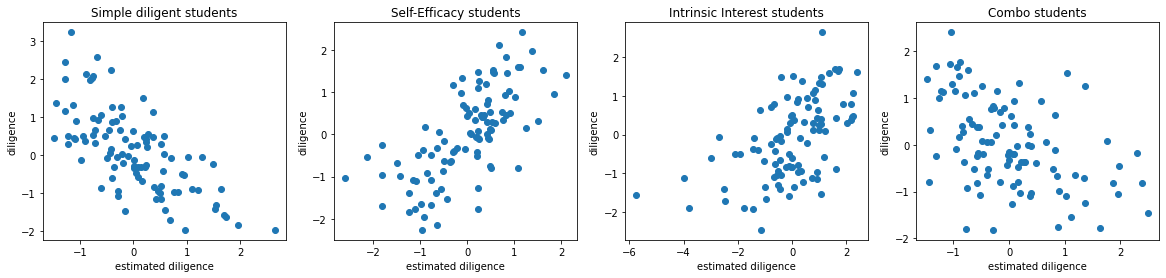

INFO:analytics.session:Comparing models with columns: ('align Pct OffTask', 'align early finish')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.4949750012625626
INFO:analytics.session:EigenValues: [1.32899795 0.67100205]
INFO:analytics.session:Factor Loadings: [[0.57358343]
 [0.57358343]]
INFO:analytics.session:Factor Variance: (array([0.6579959]), array([0.32899795]), array([0.32899795]))
INFO:analytics.session:Factor loadings: align Pct OffTask     0.573583
align early finish    0.573583
dtype: float64
INFO:analytics.session:(100,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = 0.7463121985372897	 pval = 5.053137312069588e-19
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Self-Efficacy student

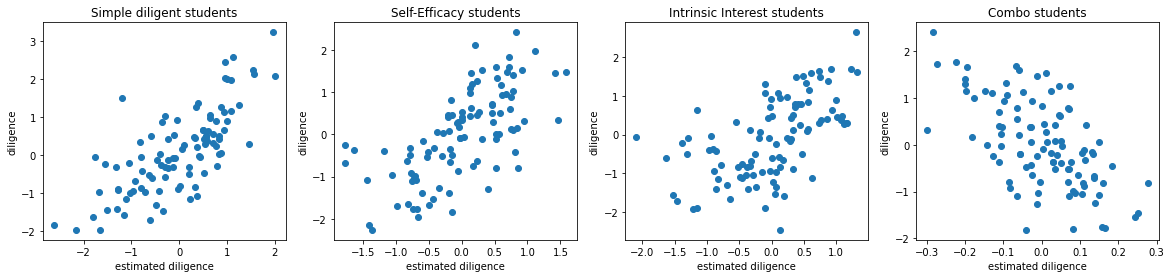

INFO:analytics.session:Comparing models with columns: ('align start speed', 'align early finish')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.4949750012625624
INFO:analytics.session:EigenValues: [1.26102745 0.73897255]
INFO:analytics.session:Factor Loadings: [[0.51090845]
 [0.51090845]]
INFO:analytics.session:Factor Variance: (array([0.5220549]), array([0.26102745]), array([0.26102745]))
INFO:analytics.session:Factor loadings: align start speed     0.510908
align early finish    0.510908
dtype: float64
INFO:analytics.session:(100,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = 0.7270756257539328	 pval = 1.0818781427784963e-17
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Self-Efficacy studen

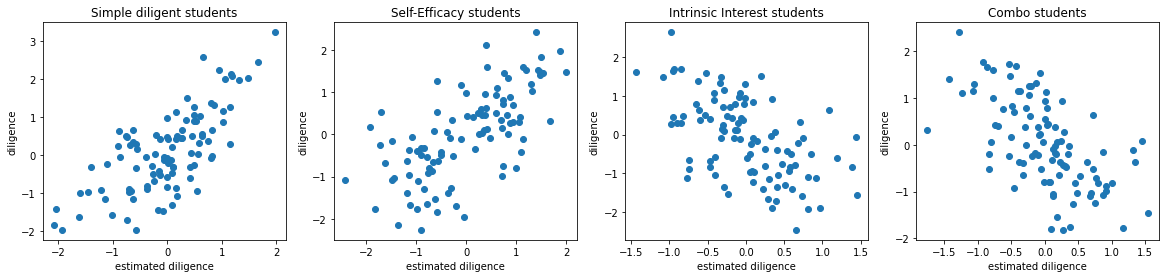

INFO:analytics.session:Comparing models with columns: ('align pct class', 'align Pct OffTask', 'align start speed')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.5984765128888758
INFO:analytics.session:EigenValues: [1.83461968 0.75314736 0.41223296]
INFO:analytics.session:Factor Loadings: [[0.88216221]
 [0.42731403]
 [0.65276235]]
INFO:analytics.session:Factor Variance: (array([1.38690612]), array([0.46230204]), array([0.46230204]))
INFO:analytics.session:Factor loadings: align pct class      0.882162
align Pct OffTask    0.427314
align start speed    0.652762
dtype: float64
INFO:analytics.session:(100,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = 0.7634431627128858	 pval = 2.5938106660759928e-20
INFO:analytics.session:**********************************************

Created 4 Combinations of length 3


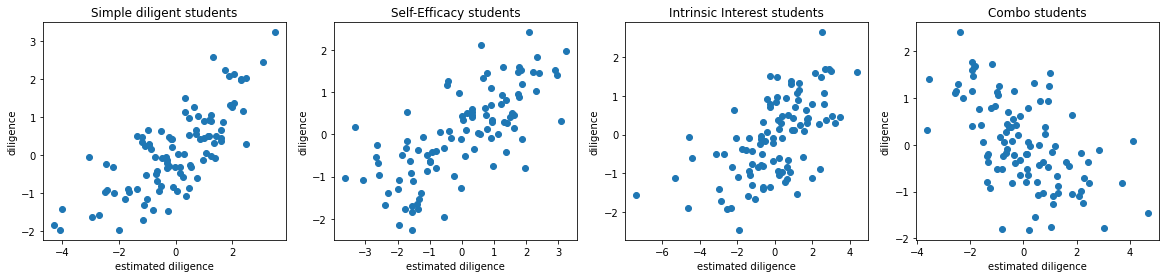

INFO:analytics.session:Comparing models with columns: ('align pct class', 'align Pct OffTask', 'align early finish')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.5564433444091513
INFO:analytics.session:EigenValues: [2.1245418  0.77979756 0.09566064]
INFO:analytics.session:Factor Loadings: [[-0.99950435]
 [-0.37175609]
 [-0.90106156]]
INFO:analytics.session:Factor Variance: (array([1.94912348]), array([0.64970783]), array([0.64970783]))
INFO:analytics.session:Factor loadings: align pct class      -0.999504
align Pct OffTask    -0.371756
align early finish   -0.901062
dtype: float64
INFO:analytics.session:(100,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = -0.7317191564033028	 pval = 5.2902001674874874e-18
INFO:analytics.session:**************************************

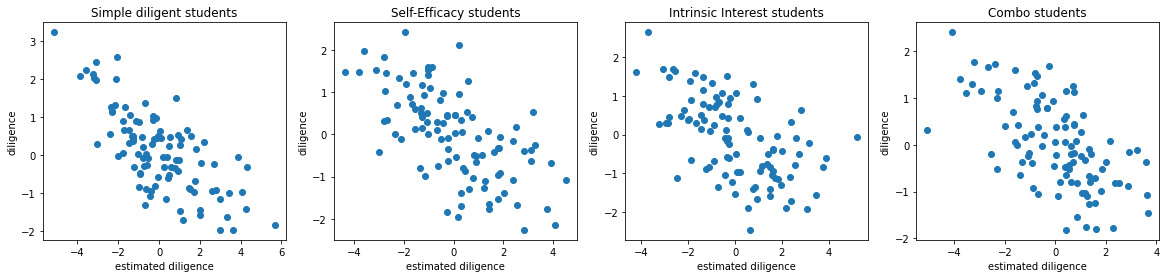

INFO:analytics.session:Comparing models with columns: ('align pct class', 'align start speed', 'align early finish')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.3593069734213729
INFO:analytics.session:EigenValues: [2.20039582 0.76604647 0.03355772]
INFO:analytics.session:Factor Loadings: [[-1.03860355]
 [-0.46430816]
 [-0.81812954]]
INFO:analytics.session:Factor Variance: (array([1.96361534]), array([0.65453845]), array([0.65453845]))
INFO:analytics.session:Factor loadings: align pct class      -1.038604
align start speed    -0.464308
align early finish   -0.818130
dtype: float64
INFO:analytics.session:(100,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = -0.7166493812032267	 pval = 5.118855990016773e-17
INFO:analytics.session:***************************************

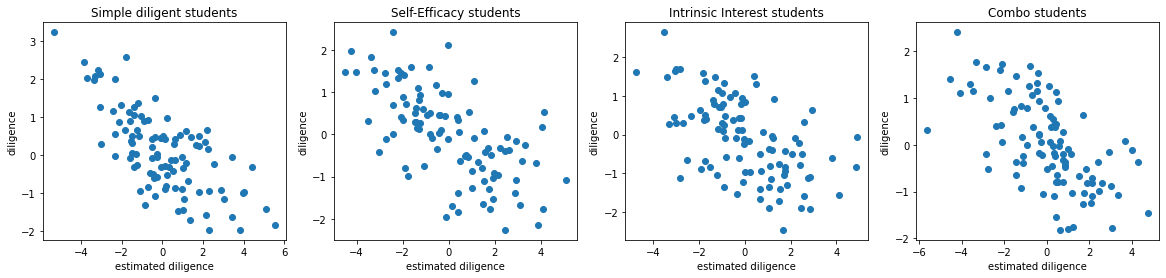

INFO:analytics.session:Comparing models with columns: ('align Pct OffTask', 'align start speed', 'align early finish')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.6148382802894012
INFO:analytics.session:EigenValues: [1.58029175 0.75017167 0.66953658]
INFO:analytics.session:Factor Loadings: [[-0.59293198]
 [-0.47043258]
 [-0.55486683]]
INFO:analytics.session:Factor Variance: (array([0.88075233]), array([0.29358411]), array([0.29358411]))
INFO:analytics.session:Factor loadings: align Pct OffTask    -0.592932
align start speed    -0.470433
align early finish   -0.554867
dtype: float64
INFO:analytics.session:(100,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = -0.8015156748216671	 pval = 1.2994830825248807e-23
INFO:analytics.session:************************************

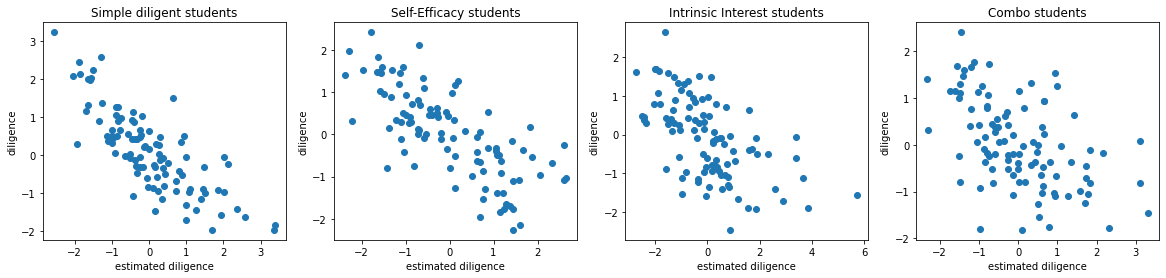

INFO:analytics.session:Comparing models with columns: ('align pct class', 'align Pct OffTask', 'align start speed', 'align early finish')
INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.41682314022869477
INFO:analytics.session:EigenValues: [2.42953796 0.79256335 0.74434142 0.03355727]
INFO:analytics.session:Factor Loadings: [[-1.03170129]
 [-0.40358741]
 [-0.48642937]
 [-0.81372179]]
INFO:analytics.session:Factor Variance: (array([2.12604703]), array([0.53151176]), array([0.53151176]))
INFO:analytics.session:Factor loadings: align pct class      -1.031701
align Pct OffTask    -0.403587
align start speed    -0.486429
align early finish   -0.813722
dtype: float64
INFO:analytics.session:(100,)
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = -0.7636720937229947	 pval = 2.488

Created 1 Combinations of length 4


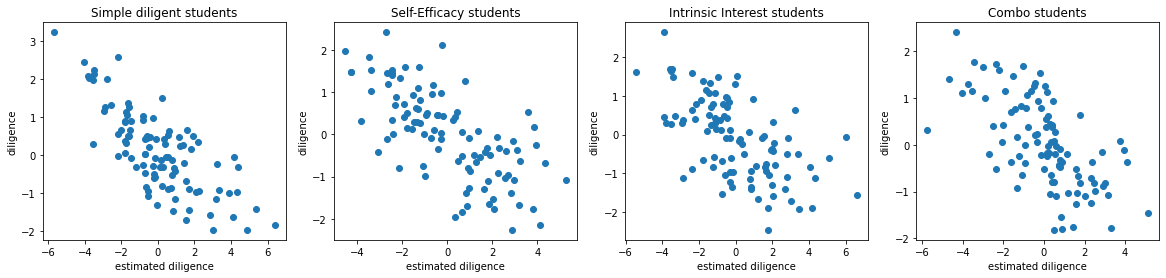

In [64]:
dil_factors = ['pct class', 'Pct OffTask', 'start speed', 'early finish']
dil_factors = [f"align {f}" for f in dil_factors]

for r in range(2,len(dil_factors)+1):
    dil_combos = list(combinations(dil_factors, r))
    print(f"Created {len(dil_combos)} Combinations of length {r}")
    for combo in dil_combos:
        n = len(batch_descs)
        plt.figure(figsize=(5*n,4))
        logger.info(f"Comparing models with columns: {combo}")
        for i, desc in enumerate(batch_descs):
            logger.info("***************************************************")
            logger.info(f"Comparing student sim: {desc}")
            ss = stu_stats[desc]
        #    cog_cols = ['accuracy', 'err_on_1_opp', 'avg_prac_opp', 'final-sim total mastery']

            xcols = combo
            ycol = "diligence"
            #Factor analysis
            df = ss.loc[:,xcols]
            kmo_all, kmo_model = calculate_kmo(df)
            logger.info(f"Overall Model Kaiser-Meyer-Olkin (KMO) Test: {kmo_model}")
            fa = FactorAnalyzer(rotation=None,  n_factors=1)
            fa.fit(df)
            # Check Eigenvalues
            ev, v = fa.get_eigenvalues()
            logger.info(f"EigenValues: {ev}")
            logger.info(f"Factor Loadings: {fa.loadings_}")
            logger.info(f"Factor Variance: {fa.get_factor_variance()}")

            loadings = pd.Series([x[0] for x in fa.loadings_], index=df.columns)
            logger.info(f"Factor loadings: {loadings}")
            X = df.mul(loadings).apply('sum', axis=1)
            logger.info(X.shape)
            Y = ss[ycol]
            corr, pval = pearsonr(X,Y)
            logger.info("******************* Pearson ********************")
            logger.info(f"R = {corr}\t pval = {pval}")

            plt.subplot(1,n,i+1)
            plt.scatter(X, Y)
            plt.title(desc)
            plt.xlabel("estimated diligence")
            plt.ylabel(ycol)
        plt.show()

#### Cronbach's Alpha

In [67]:
dil_factors = ['pct class', 'Pct OffTask', 'start speed', 'early finish']
dil_factors = [f"align {f}" for f in dil_factors]

for i, desc in enumerate(batch_descs):
    logger.info("***************************************************")
    logger.info(f"Comparing student sim: {desc}")
    ss = stu_stats[desc]
    for r in range(2,len(dil_factors)+1):
        dil_combos = list(combinations(dil_factors, r))
        print(f"Created {len(dil_combos)} Combinations of length {r}")
        for combo in dil_combos:
            logger.info(f"Calculating alpha for factors: {combo}")

#             alpha = cronbach_alpha(ss.loc[:,combo])
            alpha = CronbachAlpha(ss.loc[:,combo])
            
            logger.info(f"Alpha: {alpha}")

INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Calculating alpha for factors: ('align pct class', 'align Pct OffTask')
INFO:analytics.session:Alpha: 0.5475254941620371
INFO:analytics.session:Calculating alpha for factors: ('align pct class', 'align start speed')
INFO:analytics.session:Alpha: 0.7308376008880098
INFO:analytics.session:Calculating alpha for factors: ('align pct class', 'align early finish')
INFO:analytics.session:Alpha: 0.9489387450097715
INFO:analytics.session:Calculating alpha for factors: ('align Pct OffTask', 'align start speed')
INFO:analytics.session:Alpha: 0.43619816141953494
INFO:analytics.session:Calculating alpha for factors: ('align Pct OffTask', 'align early finish')
INFO:analytics.session:Alpha: 0.4951067826533335
INFO:analytics.session:Calculating alpha for factors: ('align start speed', 'align early finish')
INFO:analytics.session:Alpha:

Created 6 Combinations of length 2
Created 4 Combinations of length 3
Created 1 Combinations of length 4
Created 6 Combinations of length 2
Created 4 Combinations of length 3
Created 1 Combinations of length 4
Created 6 Combinations of length 2
Created 4 Combinations of length 3
Created 1 Combinations of length 4
Created 6 Combinations of length 2
Created 4 Combinations of length 3
Created 1 Combinations of length 4


### M5: Multiple Dil & Cog Measures

#### EDA of cog factors with cog ability


INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = 0.7555411949892881	 pval = 1.0518956140159734e-19
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = 0.9256456266548542	 pval = 3.769753766176405e-43


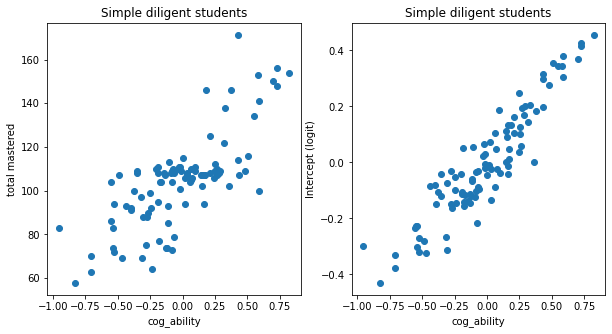

INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.4949750012625626
INFO:analytics.session:EigenValues: [1.78292652 0.21707348]
INFO:analytics.session:Factor Loadings: [[0.88483135]
 [0.88483135]]
INFO:analytics.session:Factor Variance: (array([1.56585304]), array([0.78292652]), array([0.78292652]))
INFO:analytics.session:Factor loadings: total mastered       0.884831
Intercept (logit)    0.884831
dtype: float64
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = 0.758590515324023	 pval = 6.16733124437358e-20


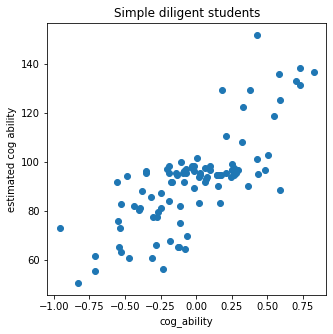

INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Self-Efficacy students
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = 0.6945939240567515	 pval = 1.1019661571399624e-15
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = 0.6972586248679041	 pval = 7.718243735883928e-16


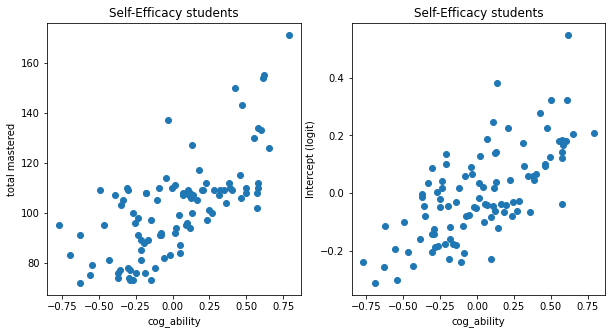

INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.4949750012625625
INFO:analytics.session:EigenValues: [1.65621542 0.34378458]
INFO:analytics.session:Factor Loadings: [[0.81007124]
 [0.81007124]]
INFO:analytics.session:Factor Variance: (array([1.31243084]), array([0.65621542]), array([0.65621542]))
INFO:analytics.session:Factor loadings: total mastered       0.810071
Intercept (logit)    0.810071
dtype: float64
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = 0.6965584658779739	 pval = 8.478446394505048e-16


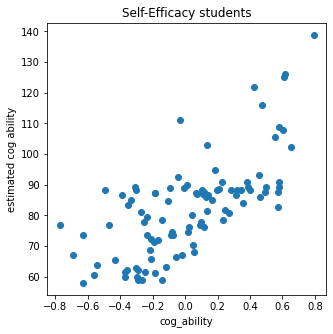

INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Intrinsic Interest students
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = 0.6701128038873865	 pval = 2.445377016970013e-14
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = 0.9187466024942189	 pval = 2.4622001721134585e-41


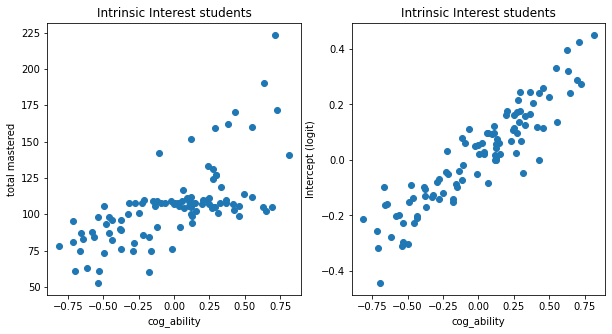

INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.494975001262563
INFO:analytics.session:EigenValues: [1.72933314 0.27066686]
INFO:analytics.session:Factor Loadings: [[0.85401003]
 [0.85401003]]
INFO:analytics.session:Factor Variance: (array([1.45866628]), array([0.72933314]), array([0.72933314]))
INFO:analytics.session:Factor loadings: total mastered       0.85401
Intercept (logit)    0.85401
dtype: float64
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = 0.6729634215799926	 pval = 1.7305477424272737e-14


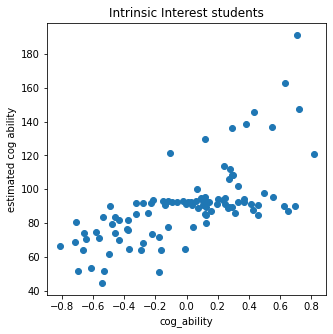

INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Combo students
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = 0.6500342647262102	 pval = 2.5173288900584265e-13
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = 0.8039065294883491	 pval = 7.635692904714684e-24


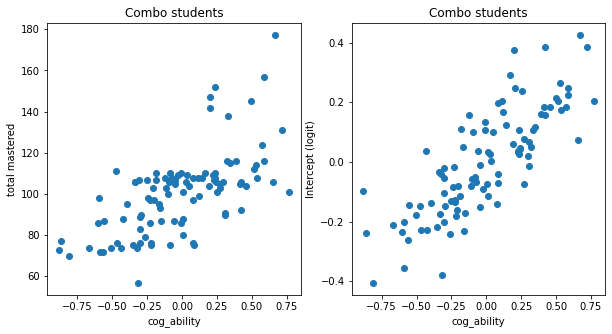

INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.49497500126256216
INFO:analytics.session:EigenValues: [1.70649546 0.29350454]
INFO:analytics.session:Factor Loadings: [[0.84053284]
 [0.84053284]]
INFO:analytics.session:Factor Variance: (array([1.41299092]), array([0.70649546]), array([0.70649546]))
INFO:analytics.session:Factor loadings: total mastered       0.840533
Intercept (logit)    0.840533
dtype: float64
INFO:analytics.session:******************* Pearson ********************
INFO:analytics.session:R = 0.6529929130287812	 pval = 1.8051221699975037e-13


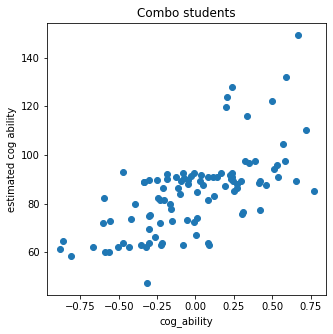

In [50]:
for i, desc in enumerate(batch_descs):
    logger.info("***************************************************")
    logger.info(f"Comparing student sim: {desc}")
    ss = stu_stats[desc]
    cog_cols = ['total mastered', 'Intercept (logit)']
    n = len(cog_cols)
    plt.figure(figsize=(5*n, 5))
    for i, ycol in enumerate(cog_cols):
        xcol = "cog_ability"
        X = ss[xcol]
        Y = ss[ycol]
        corr, pval = pearsonr(X,Y)
        logger.info("******************* Pearson ********************")
        logger.info(f"R = {corr}\t pval = {pval}")

        plt.subplot(1,n,i+1)
        plt.scatter(X, Y)
        plt.title(desc)
        plt.xlabel(xcol)
        plt.ylabel(ycol)
    plt.show()
        
    ycol = "estimated cog ability"
    xcol = "cog_ability"
    #Factor analysis
    df = ss.loc[:,cog_cols]
    kmo_all, kmo_model = calculate_kmo(df)
    logger.info(f"Overall Model Kaiser-Meyer-Olkin (KMO) Test: {kmo_model}")
    fa = FactorAnalyzer(rotation=None,  n_factors=1)
    fa.fit(df)
    # Check Eigenvalues
    ev, v = fa.get_eigenvalues()
    logger.info(f"EigenValues: {ev}")
    logger.info(f"Factor Loadings: {fa.loadings_}")
    logger.info(f"Factor Variance: {fa.get_factor_variance()}")
    
    loadings = pd.Series([x[0] for x in fa.loadings_], index=df.columns)
    logger.info(f"Factor loadings: {loadings}")
    X = ss[xcol]
    Y = df.mul(loadings).apply('sum', axis=1)
    corr, pval = pearsonr(X,Y)
    logger.info("******************* Pearson ********************")
    logger.info(f"R = {corr}\t pval = {pval}")
    plt.figure(figsize=(5, 5))

    plt.scatter(X, Y)
    plt.title(desc)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    plt.show()

#### Measure analysis

INFO:analytics.session:***************************************************
INFO:analytics.session:Comparing student sim: Simple diligent students
INFO:analytics.session:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.4867260192182035
INFO:analytics.session:EigenValues: [2.94413324 1.37681855 0.76880585 0.68693715 0.19293633 0.03036887]
INFO:analytics.session:Factor Variance: (array([2.68093093, 1.16278331]), array([0.44682182, 0.19379722]), array([0.44682182, 0.64061904]))
INFO:analytics.session:Diligence factor loadings:
align pct class      -0.499130
align Pct OffTask     0.064678
align start speed    -0.161232
align early finish   -0.428471
total mastered        0.612214
Intercept (logit)     0.570157
Name: 1, dtype: float64
INFO:analytics.session:Cognitive factor loadings:
align pct class       0.902676
align Pct OffTask     0.493245
align start speed     0.455064
align early finish    0.704390
total mastered        0.788771
Intercept (logit)     0.545351
Name: 0, dtype: float64
INF

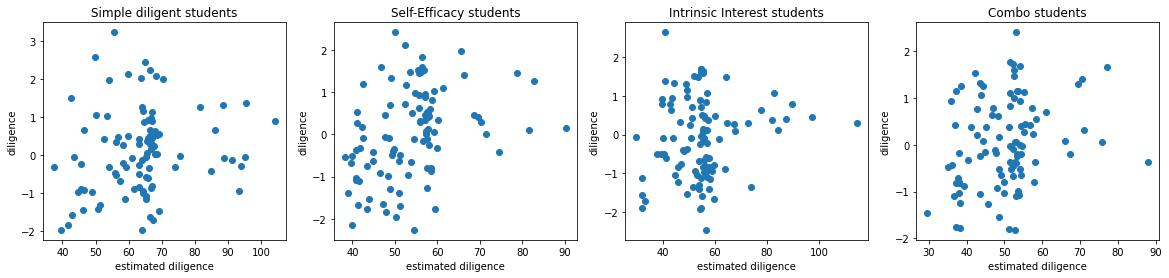

In [74]:
'''
Cognitive Factors
    AFM Student Intercept
    Total Skills mastered
    
Diligence Factors
    
1. Frequency of Off-task
2. Total Time 
3. Start Speed (procrastination)
4. Early Finish (persistence)

'''
n = len(batch_descs)
plt.figure(figsize=(5*n,4))

for i, desc in enumerate(batch_descs):
    logger.info("***************************************************")
    logger.info(f"Comparing student sim: {desc}")
    ss = stu_stats[desc]
    cog_cols = ['total mastered', 'Intercept (logit)']
    dil_cols = ['Total Time(hours)', 'mean_detect_offtask', 'start speed', 'early finish']
    dil_factors = ['pct class', 'Pct OffTask', 'start speed', 'early finish']
    dil_cols = [f"align {f}" for f in dil_factors]

    xcols= dil_cols+cog_cols
    ycol = "diligence"
    #Factor analysis
    df = ss.loc[:,xcols]
    kmo_all, kmo_model = calculate_kmo(df)
    logger.info(f"Overall Model Kaiser-Meyer-Olkin (KMO) Test: {kmo_model}")
    fa = FactorAnalyzer(rotation=None,  n_factors=2)
    fa.fit(df)
    # Check Eigenvalues
    ev, v = fa.get_eigenvalues()
    logger.info(f"EigenValues: {ev}")
#     logger.info(f"Factor Loadings: {fa.loadings_}")
    logger.info(f"Factor Variance: {fa.get_factor_variance()}")

    loadings = pd.DataFrame(fa.loadings_, index=xcols)
    dil_factor = loadings.loc[cog_cols,:].apply(lambda x: np.sum(np.absolute(x)), axis=0).argmin()
    cog_factor = loadings.loc[cog_cols,:].apply(lambda x: np.sum(np.absolute(x)), axis=0).argmax()

    logger.info(f"Diligence factor loadings:\n{loadings[dil_factor]}")
    logger.info(f"Cognitive factor loadings:\n{loadings[cog_factor]}")

    X = df.mul(loadings[dil_factor]).apply('sum', axis=1)
    logger.info(X.shape)
    Y = ss[ycol]
    corr, pval = pearsonr(X,Y)
    logger.info("******************* Pearson ********************")
    logger.info(f"R = {corr}\t pval = {pval}")

    plt.subplot(1,n,i+1)
    plt.scatter(X, Y)
    plt.title(desc)
    plt.xlabel("estimated diligence")
    plt.ylabel(ycol)
plt.show()



# Reliability Analysis

## Setup

In [75]:
def get_split_stu_parameters(sids, mastery_thres):
    sim_students = calc.get_stu_attributes(sids)
    sim_students = pd.concat([sim_students, calc.get_mastery(sids, mastery_thres)], axis=1)
    return sim_students


def get_action_counts(tx):
    action_dist = tx.groupby('student_id')['action_type'].value_counts().reset_index(name="count")
    action_dist = action_dist.pivot_table(index='student_id', columns='action_type', values='count', fill_value=0)
    action_dist['total actions'] = action_dist.sum(axis=1)
    for col in action_dist.columns:
        if col != 'total actions':
            action_dist['Pct %s' % col] = action_dist.apply(lambda x: x[col]/x['total actions'], axis=1)
            action_dist.head()

    return action_dist

def total_tx_stats(tx):

    # Total Transaction counts
    stu_stats = tx.groupby('stu_id').agg({'_id': 'count',
                                          'duration': np.sum,
                                         })
    stu_stats.rename(columns={'_id': "Total Tx",
                              'duration': 'Total Time'},
                              inplace = True)
    stu_stats['Total Time(hours)'] = stu_stats['Total Time'].apply(lambda x: x / 3600)
    logger.debug("Number of students: %i" % stu_stats.shape[0])
    logger.debug(stu_stats["Total Tx"].describe())

    # Total of each outcome
    d = tx.groupby(['stu_id','outcome'])['_id'].count().reset_index().pivot_table(
            index='stu_id', columns='outcome', values='_id', fill_value=0)

    # Prorporation of each outcome
    stu_stats = pd.concat([stu_stats, d], axis=1)
    stu_stats['Pct Correct'] = stu_stats['Correct'] / stu_stats['Total Tx']
    stu_stats['Pct Hint'] = stu_stats['Hint'] / stu_stats['Total Tx']
    stu_stats['Pct Incorrect'] = stu_stats['Incorrect'] / stu_stats['Total Tx']

    return stu_stats

def calc_stu_session_stats(tx):
    session_stats = calc_session_stats(tx)
    stu_session_stats = session_stats.groupby('stu_id')[['start speed', 'early finish', 'session length', 'pct class']].agg('mean', 'std')
    stu_session_stats['total opportunity'] = session_stats.groupby('stu_id')['session length'].sum()
    return stu_session_stats


def get_student_sessions(tx):
    ses_ids = tx['session_id'].unique().tolist()
    sids = tx['stu_id'].unique().tolist()
    # Get login-logout transactions for students
    d = pd.DataFrame(db.tutor_events.find({"stu_id": {'$in': sids}, 
                                         "type": {"$in": ["SessionStart", "SessionEnd"]}, 
                                         'session_id': {"$in": ses_ids}}))
    # Append session metadata
    sessions = pd.DataFrame(db.sessions.find({"_id": {'$in': ses_ids}}))
    sessions.drop(columns=['type'], inplace=True)
    sessions.rename(columns={"_id": "session_id"}, inplace=True)
    d = pd.merge(d, sessions, on="session_id", how='inner')
    return d


def calc_session_stats(tx):
    d = get_student_sessions(tx)

    # Calc student-session stats
    session_stats = d.pivot(index=['stu_id', 'session_id'], columns='type', values='time').reset_index()
    session_stats = pd.merge(d.loc[:, ['stu_id', 'session_id', 'start', 'end']].drop_duplicates(), session_stats, on=['stu_id', 'session_id'])

    # Start/end speed
    session_stats['start speed'] = session_stats.apply(lambda x: (x['SessionStart'] - x['start']).total_seconds()/60, axis=1)
    session_stats['early finish'] = session_stats.apply(lambda x: (x['end'] - x['SessionEnd']).total_seconds()/60, axis=1)

    # session length
    session_stats['session length'] = session_stats.apply(lambda x: (x['SessionEnd'] - x['SessionStart']).total_seconds()/60, axis=1)
    session_stats['class length'] = session_stats.apply(lambda x: (x['end'] - x['start']).total_seconds()/60, axis=1)
    session_stats['pct class'] = session_stats['session length'] / session_stats['class length']

    return session_stats




In [76]:
def calc_expected_work_rate(steps):
    # Calculate expected work time
    d = pd.DataFrame(db.kcs.find({"_id": {"$in": steps['kc'].tolist()}})).rename(columns={'_id': "kc"})
    d = pd.merge(steps, d, on="kc", how="outer")
    d['expected_duration'] = d['Attempts'] * d['m_time']
    exp_work_rate = d.groupby('stu_id')['duration'].sum() / d.groupby('stu_id')['expected_duration'].sum()
    return exp_work_rate


In [77]:
def rand_split(x):
    k = int(len(x)/2)
    s1 = random.sample(x.tolist(), k)
    return x.apply(lambda d: 0 if d in s1 else 1)
    

In [78]:
def calc_split_half_stats(ids):
    
    # Get all tx
    tx = get_tx(ids)
    tx = pd.concat([tx, tx_lblr.label_nondil_tx(tx)], axis=1)
    # Merge decisions with tx
    decisions, actions = tx_lblr.get_tx_decisions(tx)
    tx = tx_lblr.merge_decisions(tx, actions, decisions)

    # Split tx by random half sessions
    idx = tx.loc[:, ['stu_id', 'session_id']].drop_duplicates()
    idx['split_half'] = idx.groupby('stu_id')['session_id'].apply(rand_split)
    # Index tx by split half
    tx = pd.merge(tx, idx, on=['stu_id', 'session_id'], how='inner')
    
    # Get step rollup
    steps = tx.groupby('split_half').apply(step_calc.rollup_tx).reset_index()
    steps = pd.concat([steps, step_calc.label_knowledge(steps)], axis=1)

    # Calculate student non-diligent stats
    detect_offtask = tx.groupby('split_half').apply(calc.calc_detected_offtask).unstack().rename('detect_offtask')
    detect_guess = tx.groupby('split_half').apply(calc.calc_detected_guess).unstack().rename('detect_guess')
    time_on_task = tx.groupby('split_half').apply(calc.calc_time_on_task)
    time_on_task.index = time_on_task.index.swaplevel()

    # Count opportunities at each knowledge level
    kc_prac = steps.groupby('split_half').apply(step_calc.count_practice_challenge)
    kc_prac.index = kc_prac.index.swaplevel()
    over_prac = kc_prac.apply(lambda x: x['high_knowledge'] / np.sum(x), axis=1).rename("over_practice")
    kc_prac.columns = [f"{col}_practice" for col in kc_prac.columns.tolist()]

    # Calculate accuracy
    step_accuracy = steps.groupby('split_half').apply(calc_step_accuracy).unstack().rename('accuracy')

    # Calculate work rate:
    work_rate = steps.groupby('split_half').apply(calc.calc_avg_work_rate).unstack().rename('work rate')
    exp_work_rate = steps.groupby('split_half').apply(calc_expected_work_rate).unstack().rename('exp_work_rate')

    # Calculate hint usage by knowledge level
    stu_level_hints = steps.groupby(['stu_id', 'split_half', 'knowledge_level'])['Hint'].mean().unstack(level=2)
    stu_level_hints.columns = [f"{col}_mean_num_hints" for col in stu_level_hints.columns.tolist()]
    
    # Action stats
    action_dist = tx.groupby('split_half').apply(get_action_counts)
    action_dist.index = action_dist.index.swaplevel()
    
    # Total Tx Stats
    tx_stats = tx.groupby('split_half').apply(total_tx_stats)
    tx_stats.index = tx_stats.index.swaplevel()
    
    # Session stats
    ses_stats = tx.groupby('split_half').apply(calc_stu_session_stats)
    ses_stats.index = ses_stats.index.swaplevel()
    
    
    
    stats = pd.concat([detect_offtask, detect_guess, time_on_task, kc_prac,
                       step_accuracy, over_prac, work_rate, exp_work_rate, 
                       stu_level_hints, action_dist, tx_stats, ses_stats], axis=1)

    return stats#, action_dist, tx_stats, ses_stats
    

In [79]:
def cronbach_alpha(df):    # 1. Transform the df into a correlation matrix
    df_corr = df.corr()
    
    # 2.1 Calculate N
    # The number of variables equals the number of columns in the df
    N = df.shape[1]
    
    # 2.2 Calculate R
    # For this, we'll loop through the columns and append every
    # relevant correlation to an array calles "r_s". Then, we'll
    # calculate the mean of "r_s"
    rs = np.array([])
    for i, col in enumerate(df_corr.columns):
        sum_ = df_corr[col][i+1:].values
        rs = np.append(sum_, rs)
    mean_r = np.mean(rs)
    
   # 3. Use the formula to calculate Cronbach's Alpha 
    cronbach_alpha = (N * mean_r) / (1 + (N - 1) * mean_r)
    return cronbach_alpha

def CronbachAlpha(itemscores):
    itemscores = np.asarray(itemscores)
    itemvars = itemscores.var(axis=0, ddof=1)
    tscores = itemscores.sum(axis=1)
    nitems = itemscores.shape[1]

    return (nitems / (nitems-1)) * (1 - (itemvars.sum() / tscores.var(ddof=1)))

## Calculate Split-half Reliability

In [80]:
ses_calc = SessionCalculator(db)

In [81]:
split_stu_stats = {desc: {} for desc in batch_descs}
batch_size=2
for desc in batch_descs:
    ids = sids[desc][0]
    logger.info(f"Calculating split-half reliability of {len(sid)} students for batch, {desc}")
    
    
    def calc_split_stats(sids):
        d = calc_split_half_stats(sids)
        d.index.rename("stu_id", level=0, inplace=True)
        d.index.rename("split_half", level=1, inplace=True)

        args = [get_stu_parameters, sids, batch_size, [mastery_thres]]
        sim_students, runtime = batch_calc.time_calc(batch_calc.batch_calc, args)
#         logger.info(f"Calculated student params: {sim_students.shape}\tRuntime: {runtime} seconds")
        sim_students.index.rename("stu_id", inplace=True)

        result = pd.merge(sim_students, d, left_index=True, right_index=True)

        logger.info("Completed calculated and merging reliability stats: {split_stu_stats.shape}")
        return result
    
    args = [calc_split_stats, ids, batch_size]
    split_stu_stats[desc], runtime = batch_calc.time_calc(batch_calc.batch_calc, args)
    logger.info(f"Calculated student split half stats: {split_stu_stats[desc].shape}\tRuntime: {runtime} seconds")
    
    


INFO:analytics.session:Calculating split-half reliability of 100 students for batch, Simple diligent students


KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Index(['session_id'], dtype='object'). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

## Compare Reliability of estimators

### Align direction of measures and scale

In [ ]:
measures = ['pct class', 'Pct OffTask', 'start speed', 'early finish']
scaled_measures = {m: f"align {m}" for m in measures}
# Align these columns so greater value == greater diligence
align_measures = {"pct class": 1, "Pct OffTask": -1, 'start speed': -1, 'early finish': -1}
for i, desc in enumerate(batch_descs):
    logger.info(f"Aligning columns for student sim: {desc}")
    ss = split_stu_stats[desc]
    for m in measures:
        d = ss[m]
        split_stu_stats[desc][scaled_measures[m]] = align_measures[m] * (d - d.mean())/d.std() 

logger.info(f"Added new columns: {scaled_measures.values()}")

In [ ]:
measures = ['pct class', 'Pct OffTask', 'start speed', 'early finish']
scaled_measures = {m: f"align {m}" for m in measures}
# Align these columns so greater value == greater diligence
align_measures = {"pct class": 1, "Pct OffTask": -1, 'start speed': -1, 'early finish': -1}
for desc in batch_descs:
    ss = split_stu_stats[desc].unstack(level=1)
    # Calculate reliability of each measu
    for m in measures:
        logger.info(f"Calculating alpha for factors: {m}")
        alpha = CronbachAlpha(ss[m])    
        logger.info(f"Alpha: {alpha}")
        corr, pval = pearsonr(ss[m][0],ss[m][1])
        logger.info(f"Reliability: {abs(corr)}")

In [ ]:
dil_factors = ['pct class', 'Pct OffTask', 'start speed', 'early finish']
dil_factors = [f"align {f}" for f in dil_factors]

n = len(batch_descs)
# plt.figure(figsize=(5*n,4))
logger.info(f"Calculating Cronbachs for factor with measures: {dil_factors}")
for i, desc in enumerate(batch_descs):
    logger.info("***************************************************")
    logger.info(f"Comparing student sim: {desc}")
    ss = split_stu_stats[desc]
#    cog_cols = ['accuracy', 'err_on_1_opp', 'avg_prac_opp', 'final-sim total mastery']

    xcols = dil_factors
    ycol = "diligence"
    vals = []
    #Factor analysis
    for i in range(2):
        logger.info(f"Calculating factor for split_half: {i}")
        df = ss.loc[(slice(None),i),xcols]
        kmo_all, kmo_model = calculate_kmo(df)
#         logger.info(f"Overall Model Kaiser-Meyer-Olkin (KMO) Test: {kmo_model}")
        fa = FactorAnalyzer(rotation=None,  n_factors=1)
        fa.fit(df)
        # Check Eigenvalues
        ev, v = fa.get_eigenvalues()
#         logger.info(f"EigenValues: {ev}")
#         logger.info(f"Factor Loadings: {fa.loadings_}")
#         logger.info(f"Factor Variance: {fa.get_factor_variance()}")

        loadings = pd.Series([x[0] for x in fa.loadings_], index=df.columns)
#         logger.info(f"Factor loadings: {loadings}")
        X = df.mul(loadings).apply('sum', axis=1).reset_index(name=i)
        vals.append(X.drop(columns=[col for col in X.columns if col == 'split_half']))
        logger.info(X.shape)
        Y = ss.loc[(slice(None), i),ycol]
#         corr, pval = pearsonr(X,Y)
#         logger.info("******************* Pearson ********************")
#         logger.info(f"R = {corr}\t pval = {pval}")
    X = pd.merge(vals[0], vals[1], on=['stu_id'], how='outer')
    X.index = X['stu_id']
    X.drop(columns=[col for col in X.columns if type(col) != int], inplace=True)
    corr, pval = pearsonr(X[0],X[1])
    logger.info(f"Reliability: {abs(corr)}")
    alpha = CronbachAlpha(X)    
    logger.info(f"Alpha: {alpha}")
    
#     plt.subplot(1,n,i+1)
#     plt.scatter(X, Y)
#     plt.title(desc)
#     plt.xlabel("estimated diligence")
#     plt.ylabel(ycol)
# plt.show()